In [ ]:
from multi_camera.datajoint import calibrate_cameras

In [50]:
%reload_ext autoreload
%autoreload 2
# import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] ='2'
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'
import torch
import logging
import time
from argparse import ArgumentParser

import cv2
import json_tricks as json
import numpy as np

from multi_camera.datajoint.sessions import Subject, Session, Recording


from pose_pipeline.utils.jupyter import play,play_grid
from pose_pipeline.pipeline import BlurredVideo,LiftingPerson,LiftingMethod,TopDownPerson,Video
from multi_camera.datajoint.multi_camera_dj import Calibration,PersonKeypointReconstruction,SingleCameraVideo, CalibratedRecording, MultiCameraRecording,PersonKeypointReconstructionMethod
from multi_camera.datajoint.sessions import Recording
from hand_detection.hand_dj import HandPoseReconstructionMethodLookup,HandPoseReconstructionMethod, HandPoseReconstruction,HandPoseEstimationMethodLookup
from hand_detection.hand_dj import HandBbox,HandBboxMethod, HandPoseEstimation,HandPoseEstimationMethod,HandPoseEstimationVideo,MJXReconstruction
from hand_detection.hand_dj import MJXReconstructionVideo,MJXReconstructionAnalysis,HandBboxMethodLookup

[2024-05-01 14:14:04,992][INFO]: Connecting pfirouzabadi@127.0.0.1:3306
[2024-05-01 14:14:05,083][INFO]: Connected pfirouzabadi@127.0.0.1:3306


In [51]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] ='0'
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'
import numpy as np
%matplotlib inline
# %matplotlib nbagg
import cv2
import numpy as np
from typing import Callable, List, Tuple, Dict, Optional, Union
import jax
import jaxopt
from jax import vmap, jit
from jax import numpy as jnp
from tqdm import trange
from functools import partial

import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd


from multi_camera.analysis.camera import (
    robust_triangulate_points,
    triangulate_point,
    reprojection_error,
    reconstruction_error,
    get_checkboard_3d,
)


In [ ]:
import glob

calibration_files = glob.glob('./data/*143040*.mp4')
print(calibration_files)
caps = [cv2.VideoCapture(f) for f in calibration_files]

['./data/calibration_20240124_143040.23336091.mp4', './data/calibration_20240124_143040.23106523.mp4', './data/calibration_20240124_143040.23280537.mp4', './data/calibration_20240124_143040.23106529.mp4', './data/calibration_20240124_143040.23106526.mp4', './data/calibration_20240124_143040.23297516.mp4', './data/calibration_20240124_143040.23106533.mp4', './data/calibration_20240124_143040.23106539.mp4']


In [53]:
rows, cols = (4,7)
square_size = 28
# marker_size = 31
# aruco_dict_type = cv2.aruco.DICT_6X6_250
# aruco_dict = cv2.aruco.getPredefinedDictionary(aruco_dict_type)
# aruco_dict = cv2.aruco.Dictionary_get(aruco_dict_type)
# # (7, 5, 1, .8, aruco_dict)
# board = cv2.aruco.CharucoBoard_create(rows, cols, square_size/1000, marker_size/1000, aruco_dict)
# # board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
# objp = np.zeros((rows * cols, 3), np.float32)
# objp[:, :2] = np.mgrid[0 : cols, 0 : rows].T.reshape(-1, 2) * square_size  # cm
# frames = []
# calibrated_frames = []
# corners = []
# images = []
# ids=[]
# last_image = None
# shape = None
# save_images = False
# downsample = 1

Checkerboard detections 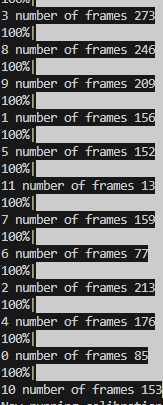

Charuco detections 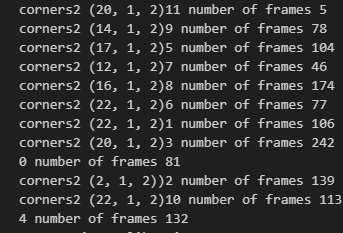
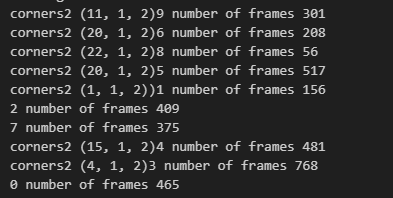

In [54]:
vid_base = '/mnt/CottonLab/mobile_system_data/20240124/m003/calibration_20240124_143224'
vid_path, vid_base = os.path.split(vid_base)

print(vid_path, vid_base)

entry = run_calibration(
    vid_base,
    vid_path,
    checkerboard_size=square_size,
    checkerboard_dim=(rows,cols),
    charuco = True,
    jax_cal=False,
    frame_skip=1,
    )

/mnt/CottonLab/mobile_system_data/20240124/m003 calibration_20240124_143224
Running calibration on calibration_20240124_143224 in /mnt/CottonLab/mobile_system_data/20240124/m003. Checkerboard size 28 mm and dim (4, 7)
Cam names: ['23106523', '23106526', '23106529', '23106533', '23106539', '23280537', '23297516', '23336091'] camera config hash: 10d8a3c714
Found 8 videos. Now detecting checkerboards.
Running ChAruco Calibration
corners2 (16, 1, 2)4 number of frames 311
corners2 (15, 1, 2)7 number of frames 214
corners2 (6, 1, 2))3 number of frames 318
corners2 (10, 1, 2)5 number of frames 391
corners2 (10, 1, 2)2 number of frames 331
corners2 (1, 1, 2))1 number of frames 343
0 number of frames 457
6 number of frames 174
Now running calibration
Extra: False. Both: True
[{'name': '0', 'size': [2048, 1536], 'matrix': [[531.3264874868972, 0.0, 1023.5], [0.0, 531.3264874868972, 767.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0

In [52]:

if np.isnan(entry["reprojection_error"]):
    raise Exception(f"Calibration failed: {entry}")

if entry["reprojection_error"] > 0.3:
    print(entry)
    print(f'The error was {entry["reprojection_error"]}. Are you sure you would like to store this in the database? [Yes/No]')

    response = input()
    if response[0].upper() != "Y":
        print("Cancelling")
        raise Exception("Calibration failed")

entry["recording_base"] = vid_base

Calibration.insert1(entry)

In [5]:
entry

{'cal_timestamp': datetime.datetime(2024, 4, 2, 13, 9, 1),
 'camera_config_hash': '07e0d11022',
 'num_cameras': 8,
 'camera_names': ['23106516',
  '23106526',
  '23106528',
  '23106529',
  '23106530',
  '23280537',
  '23297516',
  '23336091'],
 'camera_calibration': {'dist': array([[-0.15376282,  0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.01628816,  0.        ,  0.        ,  0.        ,  0.        ],
         [-0.18234472,  0.        ,  0.        ,  0.        ,  0.        ],
         [-0.17034325,  0.        ,  0.        ,  0.        ,  0.        ],
         [-0.0455877 ,  0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.04561709,  0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.00445027,  0.        ,  0.        ,  0.        ,  0.        ],
         [-0.18803985,  0.        ,  0.        ,  0.        ,  0.        ]]),
  'mtx': array([[1.79935227, 1.79935227, 1.0235    , 0.7675    ],
         [1.95945386, 1.95945386, 1.0235    , 0.76

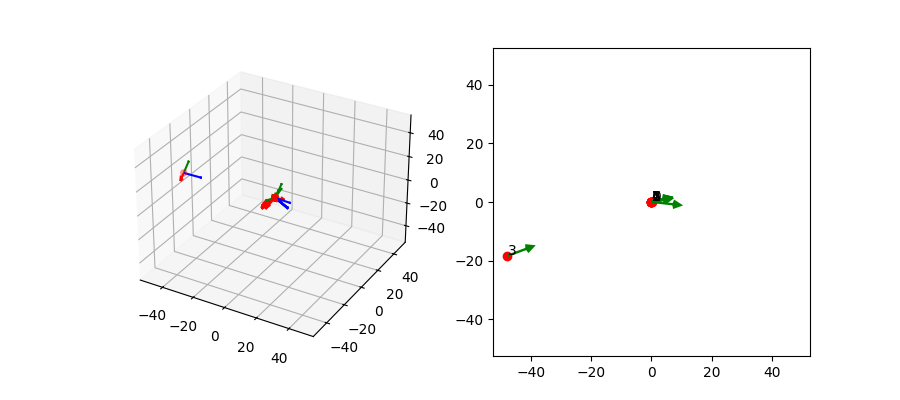

8.876271830603493

In [55]:
%matplotlib widget
if np.isnan(entry["reprojection_error"]):
        raise Exception(f"Calibration failed: {entry}")
# entry["recording_base"] = vid_base

plot_cal(entry['camera_calibration'])
# from multi_camera.datajoint.multi_camera_dj import Calibration
# Calibration.insert1(entry)
entry["reprojection_error"]

m003/calibration_20240124_143224 -->  ERROR 8.87 4x7 board 4x4bit

m003/calibration_20240124_143040 -->  ERROR 0.1625, 5x7 board 4x4bit 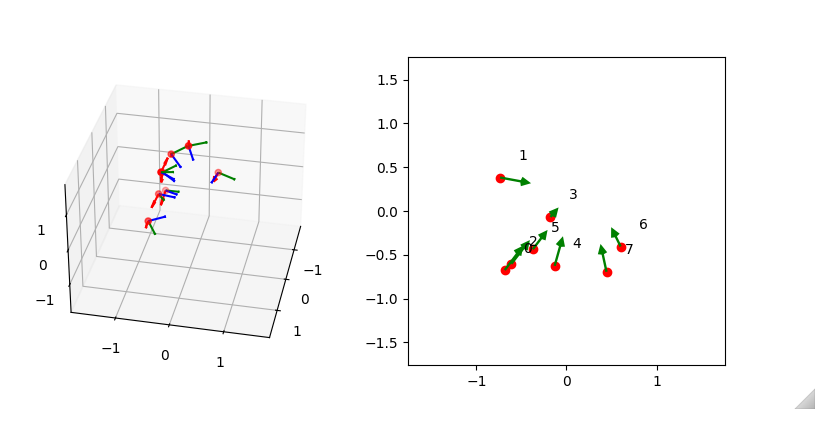

/20240426/152552 5x7 charuco James'lab environment 0.1120556 error 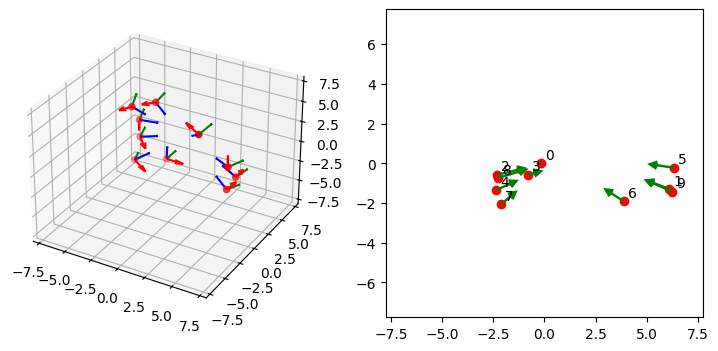
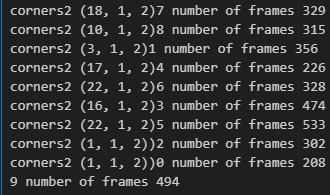


20240426/153543 5x7 big charuco on roller, james' lab environment 0.1231424 error
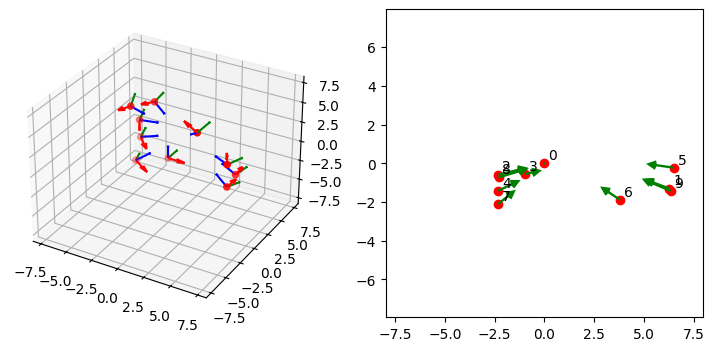

131544 5x7 6bit 39 mm loss:1.88 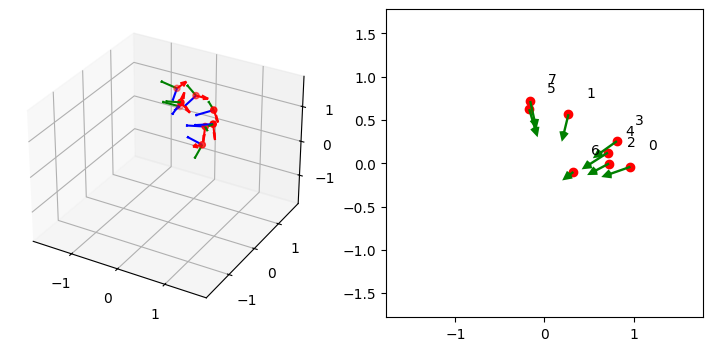
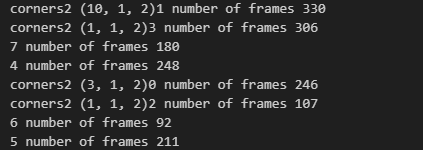

131727 5x7 6bit 39mm

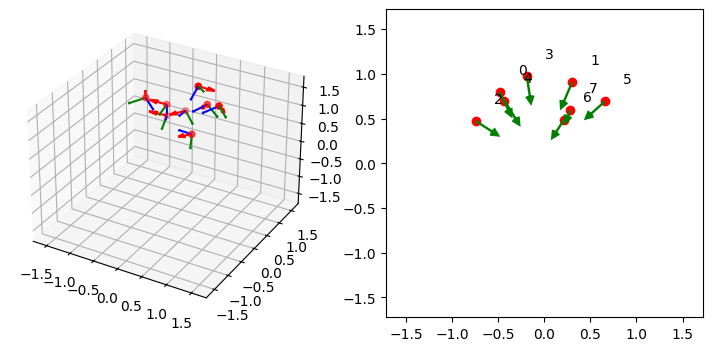

131727 (5x7) 39mm

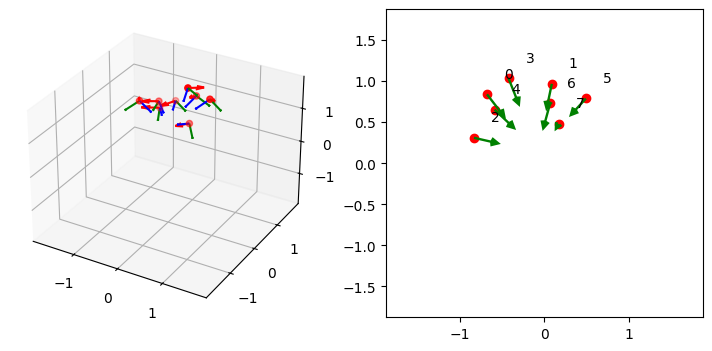

134858 marker 30mm 6x7
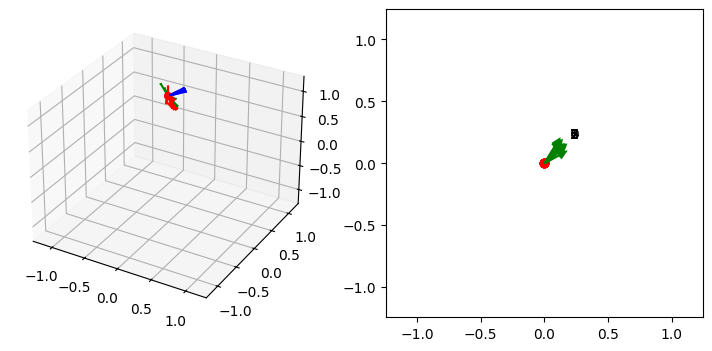

130959 5x7 4 bit
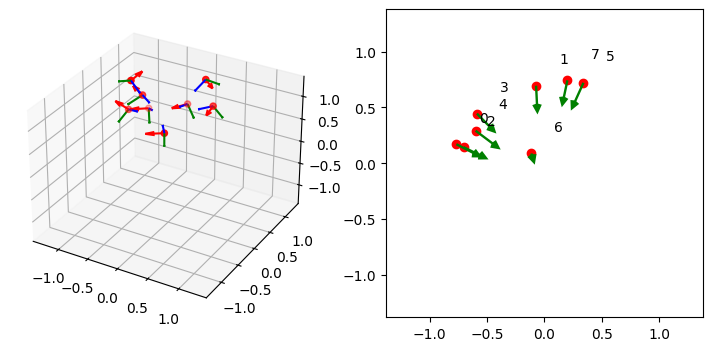

130901 5x7 4bit 
 'reprojection_error': 1.6313962710970427,

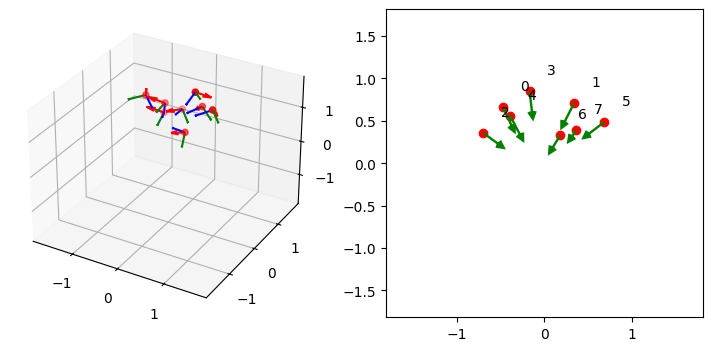


130901 5x7bit 20240404 error = 0.14 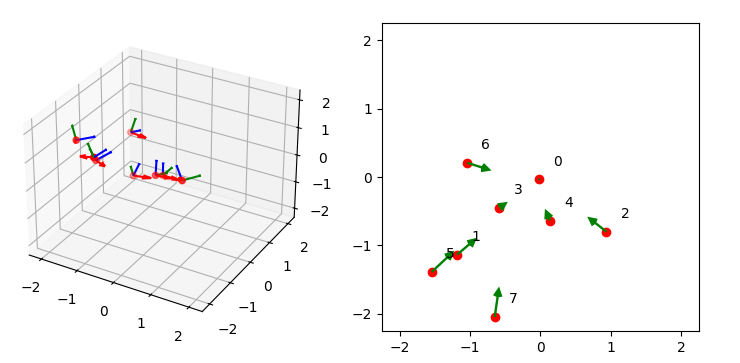

In [ ]:
def process_frame( idx, img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # chessboard_flags = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE  # + cv2.CALIB_CB_FAST_CHECK

    gray_ds = cv2.resize(gray, (img.shape[1] // downsample, img.shape[0] // downsample))
    params = cv2.aruco.DetectorParameters_create()
    corners, ids, _ = cv2.aruco.detectMarkers(gray_ds, aruco_dict, parameters=params)
    if not shape:
        shape = img.shape
    if len(corners) > 0:
        corners = corners * downsample

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        cv2.aruco.drawDetectedMarkers(gray, corners, ids)
        
        for corner in corners:
            cv2.cornerSubPix(gray, corner,
                                winSize = (11,11),
                                zeroZone = (-1,-1),
                                criteria = criteria)
        corners2 , ids2, charuco_retval = corners, ids, 0
        # charuco_retval, corners2, ids2 = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, board)
        if corners2 is not None :

            corners.append(corners2)
            ids.append(ids2)
            frames.append(idx)

        # corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        # corners.append(corners2)
        if save_images:
            images.append(img)
    else:
        charuco_retval = 0

    if save_images:
        last_image = img

    return charuco_retval

In [ ]:
downsample = 1
#  for i in range(0, 100, skip):
images = []
for c in caps:
    c.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret, img = c.read()
    images.append(img)
    if not ret or img is None:
        break
# images = images[:4]

In [ ]:
for i in range(len(images)):
    plt.imshow(images[i])
    plt.pause(0.1)

In [ ]:

# # Load the image
imboard = cv2.imread("./IMG_9089.jpg", cv2.IMREAD_GRAYSCALE)

# Create a border around the image
# imboard = cv2.copyMakeBorder(imboard, 200, 200, 200, 200, cv2.BORDER_CONSTANT, value=[125, 0, 0])

# Save the image
# cv2.imwrite("./padded_chessboard.tiff", imboard)
imboardRot = cv2.rotate(imboard, cv2.ROTATE_180)
cv2.imwrite("./IMG_9089_r.jpg", imboardRot)

True

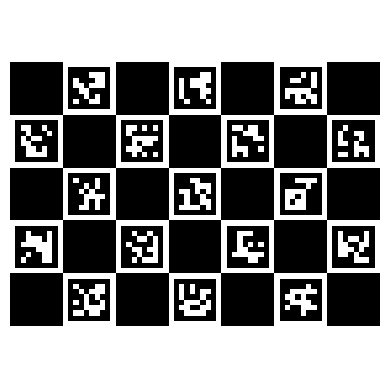

In [4]:
workdir = "./"
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
imboard = board.draw((4080, 4080))
cv2.imwrite(workdir + "Charuco7x5.png", imboard)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.show()

In [ ]:
def read_chessboards(images):
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)


    for im in images:
        frame = cv2.imread(im)
        # frame = im
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        print("=> Processing image {0}".format(gray.shape))
        
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        if len(corners)>0:
            # print(corners[0][0])

            for corner in corners:
                    cv2.cornerSubPix(gray, corner,
                                        winSize = (3,3),
                                        zeroZone = (-1,-1),
                                        criteria = criteria)
            print(len(corners), len(ids))
            print(corners[0][0])
            corners, ids, _, _ = cv2.aruco.refineDetectedMarkers(gray, board, corners, ids, rejectedImgPoints)
            # print(res)
            print(corners[0][0])
            print(len(corners), len(ids))

            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board,minMarkers=0)
            # print(ids)
            print(res2[1].shape, len(res2[2]))

            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])
            
                print('corners size ',res2[1].shape)


                # gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                # aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
                # parameters =  aruco.DetectorParameters_create()
                # corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict,
                                                                #   parameters=parameters)
                # _, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(corners, ids, gray, board)
                # SUB PIXEL DETECTION
                charuco_corners=res2[1]
                charuco_ids=res2[2]

                frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids, borderColor=(255, 0, 0))
                plt.imshow(frame_markers)
                # plt.pause(0.01)
                image = aruco.drawDetectedCornersCharuco(frame_markers, charuco_corners, charuco_ids,cornerColor = (0, 0, 250))
                plt.figure()
                plt.imshow(image)
                for i in range(len(ids)):
                    image = cv2.putText(image, 
                                        str(ids[i][0]), 
                                        (int(charuco_corners[i][0][0]),int(charuco_corners[i][0][1])), 
                                        cv2.FONT_HERSHEY_SIMPLEX,  
                                    2, (255, 50, 50) ,2, cv2.LINE_AA)
                plt.imshow(image)
                plt.pause(0.01)
        # decimator+=1

    imsize = gray.shape
    return allCorners,allIds,imsize

In [ ]:
# def read_chessboards(images):
#     """
#     Charuco base pose estimation.
#     """
#     print("POSE ESTIMATION STARTS:")
#     allCorners = []
#     allIds = []
#     decimator = 0
#     # SUB PIXEL CORNER DETECTION CRITERION
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

#     for im in images:
#         print("=> Processing image {0}".format(im.shape))
#         # frame = cv2.imread(im)
#         frame = im
#         gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
#         corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)

#         if len(corners)>0:
#             # SUB PIXEL DETECTION
#             for corner in corners:
#                 cv2.cornerSubPix(gray, corner,
#                                  winSize = (3,3),
#                                  zeroZone = (-1,-1),
#                                  criteria = criteria)
#             res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)
#             if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
#                 allCorners.append(res2[1])
#                 allIds.append(res2[2])

#         # decimator+=1

#     imsize = gray.shape
#     return allCorners,allIds,imsize

In [ ]:
images = ["./padded_chessboard.tiff", "./padded_chessboard180.tiff"]
images = ["./IMG_9089.jpg","./IMG_9089_r.jpg","./IMG_9090.jpg", "./IMG_9091.jpg","./IMG_9092.jpg"]

POSE ESTIMATION STARTS:
=> Processing image (3024, 4032)
17 17
[[1822.0568 1686.384 ]
 [1989.7899 1684.5126]
 [1984.5759 1862.7177]
 [1817.595  1868.6791]]
[[1822.0568 1686.384 ]
 [1989.7899 1684.5126]
 [1984.5759 1862.7177]
 [1817.595  1868.6791]]
17 17
(15, 1, 2) 15
corners size  (15, 1, 2)


IndexError: index 15 is out of bounds for axis 0 with size 15

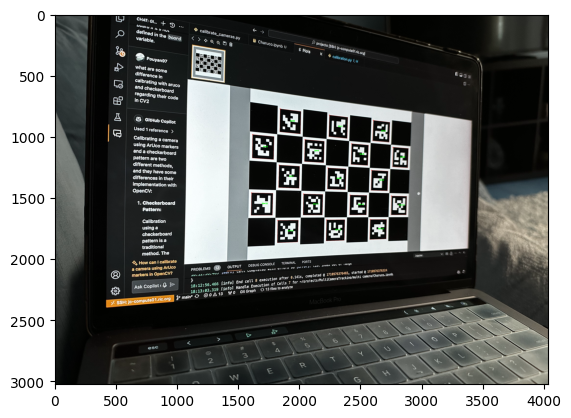

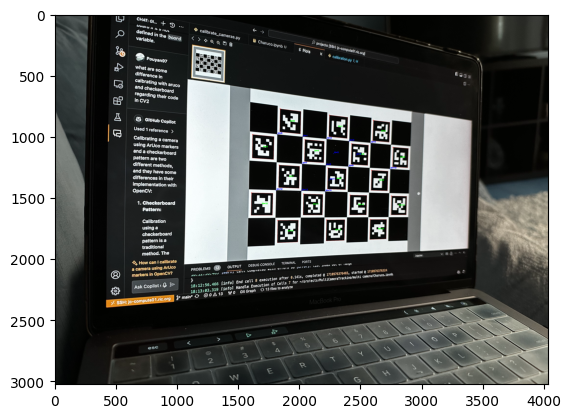

In [ ]:
allCorners,allIds,imsize=read_chessboards(images)
allIds

In [ ]:
def calibrate_camera(allCorners,allIds,imsize):
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")

    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
    #flags = (cv2.CALIB_RATIONAL_MODEL)
    (ret, camera_matrix, distortion_coefficients0,
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics,
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [ ]:
%time ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

CAMERA CALIBRATION
CPU times: user 3.54 s, sys: 94.1 ms, total: 3.63 s
Wall time: 145 ms


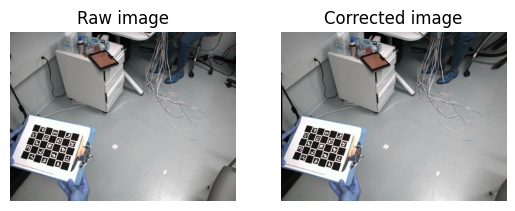

In [ ]:
i=0 # select image id
plt.figure()
frame = images[i]
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

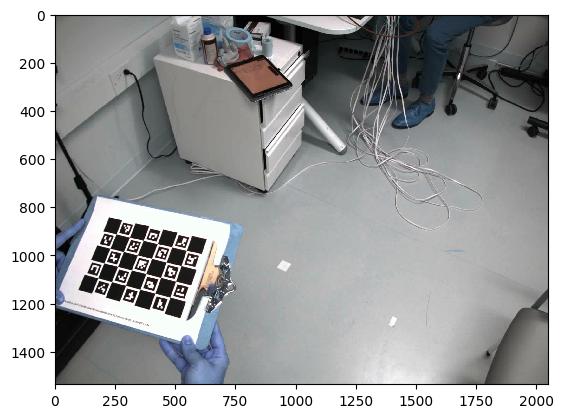

In [ ]:
frame = images[0]
#frame = cv2.undistort(src = frame, cameraMatrix = mtx, distCoeffs = dist)
plt.figure()
plt.imshow(frame, interpolation = "nearest")
plt.show()

In [ ]:
frame = cv2.rotate(images[0], cv2.ROTATE_180)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict,
                                                      parameters=parameters)
# SUB PIXEL DETECTION
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
for corner in corners:
    cv2.cornerSubPix(gray, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)

frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

corners


(array([[[2189.9282, 2248.0798],
         [2020.3221, 2227.0317],
         [2024.2354, 2043.6427],
         [2193.4885, 2060.6792]]], dtype=float32),
 array([[[2415.3765, 2038.3519],
         [2240.41  , 2021.3896],
         [2243.6833, 1834.6041],
         [2418.4229, 1846.9026]]], dtype=float32),
 array([[[1987.3097, 1997.3235],
         [1828.8473, 1982.9937],
         [1833.4384, 1808.5406],
         [1991.4601, 1817.9468]]], dtype=float32),
 array([[[2198.032 , 1788.7234],
         [2031.3062, 1779.0079],
         [2035.4275, 1599.4845],
         [2202.8928, 1605.6509]]], dtype=float32),
 array([[[1798.9901, 1765.4381],
         [1649.9531, 1757.2673],
         [1655.2749, 1588.1969],
         [1803.4772, 1592.6716]]], dtype=float32),
 array([[[1997.5875, 1553.1106],
         [1840.5284, 1548.6455],
         [1844.8976, 1380.7169],
         [2002.3971, 1380.6056]]], dtype=float32),
 array([[[2423.506 , 1561.9023],
         [2249.3462, 1558.1663],
         [2253.688 , 1379.468 ],
 

In [ ]:
corners[0][0][0]

array([2189.9282, 2248.0798], dtype=float32)

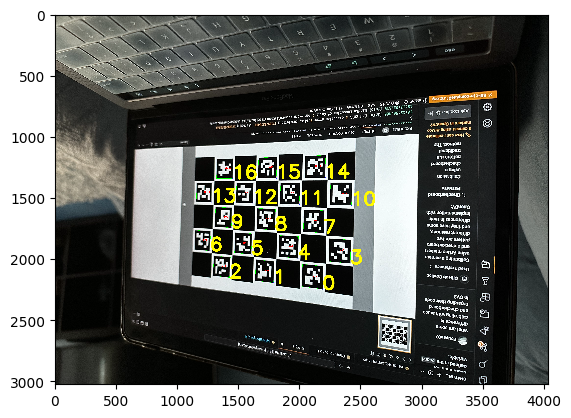

In [ ]:
plt.figure()
# image = frame_markers.copy()
for i in range(len(ids)):
    image = cv2.putText(images, 
                        str(ids[i][0]), 
                        (int(corners[i][0][0][0]),int(corners[i][0][0][1])), 
                        cv2.FONT_HERSHEY_SIMPLEX,  
                    5, (255, 250, 0) ,20, cv2.LINE_AA)
plt.imshow(image, interpolation = "nearest")

plt.show()

In [ ]:
gray = cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY)
# aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
# parameters =  aruco.DetectorParameters_create()
# corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict,
                                                    #   parameters=parameters)
# _, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(corners, ids, gray, board)
# SUB PIXEL DETECTION
charuco_corners=allCorners
charuco_ids=allIds
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
for corner in corners:
    cv2.cornerSubPix(gray, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)

frame_markers = aruco.drawDetectedMarkers(gray.copy(), allCorners[0], allIds[0],borderColor=(255, 0, 0))
image = aruco.drawDetectedCornersCharuco(frame_markers, charuco_corners, charuco_ids)
plt.figure()
plt.imshow(frame_markers)
# plt.imshow(image)

plt.show()
# corners

error: OpenCV(4.6.0) /io/opencv_contrib/modules/aruco/src/aruco.cpp:1715: error: (-215:Assertion failed) currentMarker.total() == 4 && currentMarker.type() == CV_32FC2 in function 'drawDetectedMarkers'


In [45]:
import cv2
import numpy as np
from typing import Callable, List, Tuple, Dict, Optional, Union
import jax
import jaxopt
from jax import vmap, jit
from jax import numpy as jnp
from tqdm import trange
from functools import partial

from multi_camera.analysis.camera import (
    robust_triangulate_points,
    triangulate_point,
    reprojection_error,
    reconstruction_error,
    get_checkboard_3d,
)

class ChArucoAccumulator:
    """
    Helper class to detect and store the checkerboards in a
    video.
    """

    def __init__(
        self,
        checkerboard_size=110.0,
        checkerboard_dim=(4, 6),
        downsample=1,
        save_images=False,
    ):
        self.rows, self.cols = checkerboard_dim
        self.square_size = checkerboard_size
        self.marker_size = checkerboard_size-8
        self.marker_bits = 4
        self.ARUCO_DICT = cv2.aruco.DICT_4X4_250
        self.DICT = cv2.aruco.getPredefinedDictionary(self.ARUCO_DICT)

        self.board = cv2.aruco.CharucoBoard_create(self.cols, self.rows, self.square_size, self.marker_size, self.DICT)
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        self.objp = np.zeros(((self.cols-1) * (self.rows-1), 3), np.float32)
        self.objp[:, :2] = np.mgrid[0 : self.cols-1, 0 : self.rows-1].T.reshape(-1, 2) * checkerboard_size  # cm

        self.frames = []
        self.calibrated_frames = []
        self.corners = []
        self.images = []
        self.ids=[]
        self.last_image = None

        self.shape = None

        self.save_images = save_images
        self.downsample = downsample

    def recreate(self, checkerboard_detections, checkerboard_shape=None, height=1536, width=2048):
        if checkerboard_shape is not None:
            self.objp = checkerboard_shape

        self.shape = (height, width, 3)

        # now iterate through checkerboard detections and keep frames and corners not NaN
        self.frames = []
        self.corners = []
        self.ids=[]

        for i in range(len(checkerboard_detections)):
            if np.all(~np.isnan(checkerboard_detections[i])):
                self.frames.append(i)
                self.corners.append(checkerboard_detections[i, :, None].astype(np.float32))

        keep = self.filter_corners()
        print("Keeping {} frames".format(np.mean(keep)))
        self.frames = list(np.array(self.frames)[keep])
        self.corners = list(np.array(self.corners)[keep])
        self.ids = list(np.array(self.ids)[keep])
        return self

    def process_frame(self, idx, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        # chessboard_flags = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE  # + cv2.CALIB_CB_FAST_CHECK

        gray_ds = cv2.resize(gray, (img.shape[1] // self.downsample, img.shape[0] // self.downsample))
        params = cv2.aruco.DetectorParameters_create()
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray_ds, self.DICT, parameters=params)
        corners, ids, _, _ = cv2.aruco.refineDetectedMarkers(gray_ds, self.board, corners, ids, rejectedImgPoints)

        if not self.shape:
            self.shape = img.shape
        if len(corners) > 0:
            corners = corners * self.downsample

            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

            # cv2.aruco.drawDetectedMarkers(gray, corners, ids)
            
            for corner in corners:
                cv2.cornerSubPix(gray, corner,
                                 winSize = (3,3),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
            # corners2 , ids2, charuco_retval = corners, ids, 0
            charuco_retval, corners2, ids2 = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, self.board)
            if corners2 is not None and  ids2 is not None :
                if corners2.shape[0]==(self.rows-1)*(self.cols-1):
                    self.corners.append(corners2)
                    self.ids.append(ids2)
                    self.frames.append(idx)
                else:
                    print(f'\rcorners2 {corners2.shape}', end='')

            # corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            # self.corners.append(corners2)
            if self.save_images:
                self.images.append(img)
        else:
            charuco_retval = 0

        if self.save_images:
            self.last_image = img

        return charuco_retval

    def get_rvecs_tvecs(self, mtx, dist, corners=None):
        if corners is None:
            corners = self.corners

        rvecs = []
        tvecs = []
        for imgpoint in corners:
            retval, rvec, tvec, inliers = cv2.solvePnPRansac(self.objp, imgpoint, mtx, dist, confidence=0.9, reprojectionError=30)
            rvecs.append(rvec)
            tvecs.append(tvec)

        return rvecs, tvecs

    def filter_corners(self, thresh=10.0, return_errors=False, update_self=False):
        N = len(self.frames)
        objpoints = [self.objp] * N
        imgpoints = self.corners

        h, w, _ = self.shape
        mtx = cv2.initCameraMatrix2D(objpoints, imgpoints, (w, h))
        dist = np.zeros((5,))

        corners = self.corners
        rvecs, tvecs = self.get_rvecs_tvecs(mtx, dist, self.corners)

        print(len(rvecs), len(tvecs), len(corners))
        errors = []
        for i in range(len(rvecs)):
            imgpoints2, _ = cv2.projectPoints(self.objp, rvecs[i], tvecs[i], mtx, dist)
            error = cv2.norm(corners[i], imgpoints2, cv2.NORM_L2)

            errors.append(error)

        if update_self:
            keep = np.array(errors) < thresh
            print("Keeping {} frames".format(np.mean(keep)))
            self.frames = list(np.array(self.frames)[keep])
            self.corners = list(np.array(self.corners)[keep])

        if return_errors:
            return np.array(errors)
        else:
            return np.array(errors) < thresh

    def calibrate_camera(self, flags=None, max_frames=100, filter=False):
        frames = self.frames
        N = len(frames)
        objpoints = [self.objp] * N
        imgpoints = self.corners

        if filter:
            keep = self.filter_corners()
            objpoints = list(np.array(objpoints)[keep])
            imgpoints = list(np.array(imgpoints)[keep])
            frames = list(np.array(frames)[keep])
            N = len(frames)

        # if N > max_frames take an approximately evently space subset of both lists
        # to make the total max_frames. cv2 calibration starts taking excessively long
        # much beyond this
        if N > max_frames:
            idx = np.linspace(0, N - 1, max_frames).astype(int)
            # randomly sample a set of frames
            # idx = np.random.choice(N, max_frames, replace=False)
            objpoints = list(np.array(objpoints)[idx])
            imgpoints = list(np.array(imgpoints)[idx])
            self.calibrated_frames = [self.frames[i] for i in idx.tolist()]
        else:
            self.calibrated_frames = self.frames

        h, w, _ = self.shape

        if True:
            if flags is None:
                flags = (
                    cv2.CALIB_FIX_K2
                    | cv2.CALIB_FIX_K3
                    | cv2.CALIB_FIX_K4
                    | cv2.CALIB_FIX_K5
                    | cv2.CALIB_ZERO_TANGENT_DIST
                    | cv2.CALIB_FIX_PRINCIPAL_POINT
                    | cv2.CALIB_FIX_ASPECT_RATIO
                    | cv2.CALIB_RATIONAL_MODEL
                    | cv2.CALIB_USE_INTRINSIC_GUESS
                )
            initial_matrix = np.array([[1950, 0, w / 2], [0, 1950, h / 2], [0, 0, 1]])
            (ret, mtx, dist,
                rvecs, tvecs,
                stdDeviationsIntrinsics, stdDeviationsExtrinsics,
                perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=imgpoints,
                      charucoIds=self.ids,
                      board=self.board,
                      imageSize=(h, w),
                      cameraMatrix=initial_matrix,
                      distCoeffs=np.zeros((5,1)),
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

            # _, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
            #     objpoints,
            #     imgpoints,
            #     (w, h),
            #     initial_matrix,
            #     np.zeros((5,)),
            #     flags=flags,
            # )

            if dist[0] > 0:
                print("Warning: distortion is positive")
                flags = flags | cv2.CALIB_FIX_K1
                (ret, mtx, dist,
                rvecs, tvecs,
                stdDeviationsIntrinsics, stdDeviationsExtrinsics,
                perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=imgpoints,
                      charucoIds=self.ids,
                      board=self.board,
                      imageSize=self.shape,
                      cameraMatrix=initial_matrix,
                      distCoeffs=np.zeros((5,1)),
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))


            # print(mtx.astype(int))
            # print(dist)
            # newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

        else:
            mtx = cv2.initCameraMatrix2D(objpoints, imgpoints, (w, h))
            dist = np.zeros((5,))

            print(mtx.astype(int))

        # rvecs = []
        # tvecs = []
        # for imgpoint in self.corners:
        #     retval, rvec, tvec, inliers = cv2.solvePnPRansac(self.objp, imgpoint, mtx, dist, confidence=0.9, reprojectionError=30)
        #     rvecs.append(rvec)
        #     tvecs.append(tvec)

        self.calibrated_frames = self.frames
        return {
            "mtx": mtx,
            "dist": dist,
            "rvecs": rvecs,
            "tvecs": tvecs,
            "frames": self.calibrated_frames,
            "objpoints": objpoints,
            "imgpoints": imgpoints,
        }

    def get_points(self, idx):
        return [self.objp] * len(idx), list(np.array(self.corners)[idx])


class CheckerboardAccumulator:
    """
    Helper class to detect and store the checkerboards in a
    video.
    """

    def __init__(
        self,
        checkerboard_size=110.0,
        checkerboard_dim=(4, 6),
        downsample=1,
        save_images=False,
    ):
        self.rows, self.cols = checkerboard_dim

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        self.objp = np.zeros((self.rows * self.cols, 3), np.float32)
        self.objp[:, :2] = np.mgrid[0 : self.cols, 0 : self.rows].T.reshape(-1, 2) * checkerboard_size  # cm

        self.frames = []
        self.calibrated_frames = []
        self.corners = []
        self.images = []
        self.last_image = None

        self.shape = None

        self.save_images = save_images
        self.downsample = downsample

    def recreate(self, checkerboard_detections, checkerboard_shape=None, height=1536, width=2048):
        if checkerboard_shape is not None:
            self.objp = checkerboard_shape

        self.shape = (height, width, 3)

        # now iterate through checkerboard detections and keep frames and corners not NaN
        self.frames = []
        self.corners = []

        for i in range(len(checkerboard_detections)):
            if np.all(~np.isnan(checkerboard_detections[i])):
                self.frames.append(i)
                self.corners.append(checkerboard_detections[i, :, None].astype(np.float32))

        keep = self.filter_corners()
        print("Keeping {} frames".format(np.mean(keep)))
        self.frames = list(np.array(self.frames)[keep])
        self.corners = list(np.array(self.corners)[keep])

        return self

    def process_frame(self, idx, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        chessboard_flags = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE  # + cv2.CALIB_CB_FAST_CHECK

        gray_ds = cv2.resize(gray, (img.shape[1] // self.downsample, img.shape[0] // self.downsample))
        ret, corners = cv2.findChessboardCorners(gray_ds, (self.cols, self.rows), chessboard_flags)

        if not self.shape:
            self.shape = img.shape

        if ret:
            corners = corners * self.downsample

            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

            self.frames.append(idx)
            self.corners.append(corners2)

            if self.save_images:
                self.images.append(img)

        if self.save_images:
            self.last_image = img

        return ret

    def get_rvecs_tvecs(self, mtx, dist, corners=None):
        if corners is None:
            corners = self.corners

        rvecs = []
        tvecs = []
        for imgpoint in corners:
            retval, rvec, tvec, inliers = cv2.solvePnPRansac(self.objp, imgpoint, mtx, dist, confidence=0.9, reprojectionError=30)
            rvecs.append(rvec)
            tvecs.append(tvec)

        return rvecs, tvecs

    def filter_corners(self, thresh=10.0, return_errors=False, update_self=False):
        N = len(self.frames)
        objpoints = [self.objp] * N
        imgpoints = self.corners

        h, w, _ = self.shape
        mtx = cv2.initCameraMatrix2D(objpoints, imgpoints, (w, h))
        dist = np.zeros((5,))

        corners = self.corners
        rvecs, tvecs = self.get_rvecs_tvecs(mtx, dist, self.corners)

        print(len(rvecs), len(tvecs), len(corners))
        errors = []
        for i in range(len(rvecs)):
            imgpoints2, _ = cv2.projectPoints(self.objp, rvecs[i], tvecs[i], mtx, dist)
            error = cv2.norm(corners[i], imgpoints2, cv2.NORM_L2)

            errors.append(error)

        if update_self:
            keep = np.array(errors) < thresh
            print("Keeping {} frames".format(np.mean(keep)))
            self.frames = list(np.array(self.frames)[keep])
            self.corners = list(np.array(self.corners)[keep])

        if return_errors:
            return np.array(errors)
        else:
            return np.array(errors) < thresh

    def calibrate_camera(self, flags=None, max_frames=100, filter=False):
        frames = self.frames
        N = len(frames)
        objpoints = [self.objp] * N
        imgpoints = self.corners

        if filter:
            keep = self.filter_corners()
            objpoints = list(np.array(objpoints)[keep])
            imgpoints = list(np.array(imgpoints)[keep])
            frames = list(np.array(frames)[keep])
            N = len(frames)

        # if N > max_frames take an approximately evently space subset of both lists
        # to make the total max_frames. cv2 calibration starts taking excessively long
        # much beyond this
        if N > max_frames:
            idx = np.linspace(0, N - 1, max_frames).astype(int)
            # randomly sample a set of frames
            # idx = np.random.choice(N, max_frames, replace=False)
            objpoints = list(np.array(objpoints)[idx])
            imgpoints = list(np.array(imgpoints)[idx])
            self.calibrated_frames = [self.frames[i] for i in idx.tolist()]
        else:
            self.calibrated_frames = self.frames

        h, w, _ = self.shape

        if True:
            if flags is None:
                flags = (
                    cv2.CALIB_FIX_K2
                    | cv2.CALIB_FIX_K3
                    | cv2.CALIB_FIX_K4
                    | cv2.CALIB_FIX_K5
                    | cv2.CALIB_ZERO_TANGENT_DIST
                    | cv2.CALIB_FIX_PRINCIPAL_POINT
                    | cv2.CALIB_FIX_ASPECT_RATIO
                )

            initial_matrix = np.array([[1950, 0, w / 2], [0, 1950, h / 2], [0, 0, 1]])

            _, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                objpoints,
                imgpoints,
                (w, h),
                initial_matrix,
                np.zeros((5,)),
                flags=flags,
            )

            if dist[0] > 0:
                print("Warning: distortion is positive")
                flags = flags | cv2.CALIB_FIX_K1
                _, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                    objpoints,
                    imgpoints,
                    (w, h),
                    initial_matrix,
                    np.zeros((5,)),
                    flags=flags,
                )

            print(mtx.astype(int))
            print(dist)
            # newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

        else:
            mtx = cv2.initCameraMatrix2D(objpoints, imgpoints, (w, h))
            dist = np.zeros((5,))

            print(mtx.astype(int))

        rvecs = []
        tvecs = []
        for imgpoint in self.corners:
            retval, rvec, tvec, inliers = cv2.solvePnPRansac(self.objp, imgpoint, mtx, dist, confidence=0.9, reprojectionError=30)
            rvecs.append(rvec)
            tvecs.append(tvec)

        self.calibrated_frames = self.frames
        return {
            "mtx": mtx,
            "dist": dist,
            "rvecs": rvecs,
            "tvecs": tvecs,
            "frames": self.calibrated_frames,
            "objpoints": objpoints,
            "imgpoints": imgpoints,
        }

    def get_points(self, idx):
        return [self.objp] * len(idx), list(np.array(self.corners)[idx])


def get_checkerboards(filenames, max_frames=None, skip=1, multithread=False, filter_frames=True, charuco=True, **kwargs):
    """
    Detect checkboards in a list of videos.

        Parameters:
            filenames (list) : list of pths to videos
            max_frames (int, optional) : maximum number of frames to parse
            skip (int, optional) : skip between frames to detect
            multithread (boolean, optional): where to have a per-video frame
            kwargs : optional parameters passed to the accumulator

        Returns:
            list of CheckboardAccumulators for each video
    """

    num_views = len(filenames)

    caps = [cv2.VideoCapture(f) for f in filenames]
    if charuco:
        print("Running ChAruco Calibration")
        parsers = [ChArucoAccumulator(**kwargs) for _ in range(num_views)]
    else:
        parsers = [CheckerboardAccumulator(**kwargs) for _ in range(num_views)]
    frames = int(caps[0].get(cv2.CAP_PROP_FRAME_COUNT))
    frames = min(max_frames or frames, frames)
    
    if multithread == False:
        for i in range(0, frames, skip):
            for c, p in zip(caps, parsers):
                c.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, img = c.read()

                if not ret or img is None:
                    break

                p.process_frame(i, img)

    else:
        from multiprocessing.dummy import Pool as ThreadPool

        pool = ThreadPool(num_views)

        def process_video(params):
            cap, parser, idx = params
            if idx == 0:
                progress_fn = range
            else:
                progress_fn = range

            for i in progress_fn(0, frames, skip):
                if skip != 1:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, img = cap.read()
                if not ret or img is None:
                    break

                parser.process_frame(i, img)
            print(idx, 'number of frames' ,len(parser.frames))
            return parser

        parsers = pool.map(process_video, zip(caps, parsers, range(num_views)))

    for c in caps:
        c.release()

    # for p in parsers:
    #    p.filter_corners(update_self=True)

    return parsers


def get_checkerboard_points(parsers: List[CheckerboardAccumulator]):
    """
    Extract the checkerboard points from a list of parsers
    """

    frames = np.sort(np.unique(np.concatenate([p.frames for p in parsers])))
    N = parsers[0].objp.shape[0]  # number of coordinates in pattern
    # N = (parsers[0].rows-1)*(parsers[0].cols-1)
    checkerboard_points = np.zeros((len(parsers), len(frames), N, 2)) * np.nan

    # convert format from the parser to a matrix of observations with nan for missing
    for i, p in enumerate(parsers):
        for j, f in enumerate(frames):
            idx = np.where(p.frames == f)[0]
            if len(idx) == 1:
                # print(f, idx,checkerboard_points[i, j, :, :].shape, p.corners[idx[0]].shape)
                checkerboard_points[i, j, :, :] = p.corners[idx[0]][:, 0, :]

    N, frames, _, _ = checkerboard_points.shape
    return checkerboard_points


def filter_keypoints(keypoints_2d, min_visible=3):
    """
    Only keep the times where keypoints are visible from multiple perspectives
    """

    visible = np.sum(~np.isnan(keypoints_2d[:, :, 0, 0]), axis=0)
    return keypoints_2d[:, visible >= min_visible]


def extract_origin(camera_params, checkerboard_points):
    cal3d = triangulate_point(camera_params, checkerboard_points[:, 0])

    x0 = cal3d[0]
    x = cal3d[5] - x0
    z = cal3d[18] - x0

    x = x / np.linalg.norm(x)
    z = -z / np.linalg.norm(z)
    y = -np.cross(x, z)

    board_rotation = np.stack([x, y, z])
    return x0, board_rotation


def shift_calibration(camera_params, offset, rotation=np.eye(3), zoffset=None):
    from jaxlie import SO3

    camera_params = camera_params.copy()
    offset = offset / 1000.0

    camera_rotations = vmap(lambda x: SO3.exp(x).as_matrix())(camera_params["rvec"])
    tvec = camera_params["tvec"] + camera_rotations @ offset.reshape((3,))
    rvec = vmap(lambda x: (SO3.exp(x) @ SO3.from_matrix(rotation.T)).log())(camera_params["rvec"])

    camera_params["rvec"] = rvec
    camera_params["tvec"] = tvec

    if zoffset:
        camera_params = shift_calibration(camera_params, np.array([0, 0, -zoffset]))

    return camera_params


def initialize_group_calibration(parsers, max_cv2_frames=50):
    """
    Use detected checkerboards to initialize calibration parameters

    Parameters:
        parsers (List[CheckerboardAccumulator]) : detection of checkerboards

    Returns:
        calibration dictionary - contains intrinsic and extrinsic parameters and distortion
        checkerboard_params - initial location and rotations of checkerboards
        checkerboard_points - matrix of 2D corners (cameras X points X 2)
    """

    import itertools
    from jax import jit, vmap
    from jax import numpy as jnp
    from jaxlie import SO3, SE3

    ### First build up a mapping from all the cameras for the calibration graph

    # get the checkerboard points
    checkerboard_points = get_checkerboard_points(parsers)
    checkerboard_frames = np.sort(np.unique(np.concatenate([p.frames for p in parsers])))

    # make a map of the first pairs of frames where a checkerboard was found on both
    found = ~np.isnan(checkerboard_points[:, :, 0, 0])

    N = found.shape[0]
    matches = np.zeros((N, N), dtype=object)

    for i in range(N):
        matches[i, i] = np.array([])
        for j in range(i + 1, N):
            both = np.logical_and(found[i], found[j])
            idx = np.where(both)[0]
            if len(idx) > 0:
                # if idx is greater than 10, then take an even spaced 10
                if len(idx) > max_cv2_frames:
                    idx = idx[np.linspace(0, len(idx) - 1, max_cv2_frames).astype(int)]
                idx = checkerboard_frames[idx]
                matches[i, j] = idx
                matches[j, i] = idx

    # now use numpy map over the matrix and get counts
    get_count = lambda x: len(x) if type(x) == np.ndarray else 0
    matrix = np.vectorize(get_count)(matches)

    display(matrix)

    from scipy.sparse import csr_matrix
    from scipy.sparse.csgraph import reverse_cuthill_mckee

    matrix_csr = csr_matrix(matrix)

    # Applying reverse Cuthill-McKee algorithm
    reordering = reverse_cuthill_mckee(matrix_csr)
    reordered_matrix = matrix[reordering][:, reordering]
    display(reordered_matrix)

    # Step 1: Identify the hub node
    origin = np.argmax((matrix**2).sum(axis=0))

    # Step 2: Build the list of pairs to create a subgraph
    subgraph_edges = []
    visited = [origin]

    while len(visited) < len(matrix):
        # Find the neighbor with the highest weight that hasn't been visited yet
        max_weight = -1
        next_node = None
        for i in visited:
            for j in range(len(matrix)):
                if j not in visited and matrix[i, j] > max_weight:
                    max_weight = matrix[i, j]
                    next_node = (i, j, matrix[i, j])

        # Add the edge to the subgraph and mark the node as visited
        subgraph_edges.append(next_node)
        visited.append(next_node[1])

    assert max_weight > 0, "Missing edges found in the calibration graph"
    display(subgraph_edges)

    # find the row with the most calibrated cameras to call the origin
    print(f"Using camera {origin} as the origin")
    initialized = np.zeros((N,), dtype=bool)
    initialized[origin] = True

    Rs = np.zeros((N, 3, 3))
    Ts = np.zeros((N, 3))

    Rs[origin] = np.eye(3)  # establish the first camera as the reference

    ### Now initialize the camera calibrations
    cals = [p.calibrate_camera() for p in parsers]

    for (
        i,
        j,
        w,
    ) in subgraph_edges:  # in itertools.chain.from_iterable(itertools.repeat(np.arange(0, N), N * 2)):
        # iterate through cameras as a reference

        if ~initialized[i]:
            continue

        if initialized[j]:
            # no need to double compute
            continue

        assert type(matches[i, j]) == np.ndarray, f"No matches between {i} and {j}: {matches[i, j]}"

        p1 = parsers[i]
        p2 = parsers[j]

        frames = matches[i, j]

        print(f"Linking {i} -> {j} using {len(frames)} frames")

        objpoints = [p1.objp] * len(frames)

        idx1 = [p1.frames.index(f) for f in frames]
        im1points = [p1.corners[i] for i in idx1]

        idx2 = [p2.frames.index(f) for f in frames]
        im2points = [p2.corners[i] for i in idx2]

        h, w, _ = p1.shape

        cal1 = cals[i]
        cal2 = cals[j]

        stereocalib_criteria = (
            cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            1000,
            1e-6,
        )
        stereocalib_flags = cv2.CALIB_USE_INTRINSIC_GUESS

        res = cv2.stereoCalibrate(
            objpoints,
            im1points,
            im2points,
            cal1["mtx"].copy(),
            cal1["dist"].copy(),
            cal2["mtx"].copy(),
            cal2["dist"].copy(),
            (h, w),
            criteria=stereocalib_criteria,
            flags=stereocalib_flags,
        )

        retval, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = res

        # adjust rotation and translation based on the reference camera
        T = T[:, 0] + R @ Ts[i]
        R = R @ Rs[i]

        Rs[j] = R
        Ts[j] = T

        initialized[j] = True

    if np.any(~initialized):
        print("Not all cameras initialized. Calibration graph not fully connected")

    # now put it the standard structure
    camera_params = {
        "mtx": np.array([[c["mtx"][0, 0], c["mtx"][1, 1], c["mtx"][0, 2], c["mtx"][1, 2]] for c in cals]) / 1000.0,
        "dist": np.array([c["dist"].reshape((-1)) for c in cals]),
        "rvec": vmap(lambda x: SO3.from_matrix(x).log())(Rs),
        "tvec": Ts / 1000.0,
    }

    # TODO: get better initial estimates of checkerboard rvecs
    N = checkerboard_points.shape[1]
    checkerboard_rvecs = np.zeros((N, 3))
    checkerboard_tvecs = np.zeros((N, 3))

    checkerboard_params = {"rvecs": checkerboard_rvecs, "tvecs": checkerboard_tvecs}

    return camera_params, checkerboard_params, checkerboard_points


def checkerboard_reprojection_loss(camera_params, checkerboard_params, checkerboard_points, objp):
    checkerboard_rvecs = checkerboard_params["rvecs"]
    checkerboard_tvecs = checkerboard_params["tvecs"]

    estimated_3d_points = vmap(lambda a, b: get_checkboard_3d(a, b, objp))(checkerboard_rvecs, checkerboard_tvecs)
    err = reprojection_error(camera_params, checkerboard_points, estimated_3d_points)

    norm = False
    if norm:
        # err = jnp.linalg.norm(err, axis=-1) ** 2
        return jnp.nanmean(err**2)
    else:
        return jnp.nanmean(jnp.abs(err))


def checkerboard_reconstruction_loss(camera_params, checkerboard_params, checkerboard_points, objp, norm=False):
    checkerboard_rvecs = checkerboard_params["rvecs"]
    checkerboard_tvecs = checkerboard_params["tvecs"]

    estimated_3d_points = vmap(lambda a, b: get_checkboard_3d(a, b, objp))(checkerboard_rvecs, checkerboard_tvecs)
    err = reconstruction_error(camera_params, checkerboard_points, estimated_3d_points, stop_grad=True)

    if norm:
        # err = jnp.linalg.norm(err, axis=-1) ** 2
        return jnp.nanmean(err**2)
    else:
        return jnp.nanmean(jnp.abs(err))


@jit
def checkerboard_loss(checkerboard_params, camera_params, checkerboard_points, objp):
    # return checkerboard_reconstruction_loss(camera_params, checkerboard_params, checkerboard_points, objp)
    return checkerboard_reprojection_loss(camera_params, checkerboard_params, checkerboard_points, objp)


@jit
def camera_loss(camera_params, checkerboard_params, checkerboard_points, objp):
    # return checkerboard_reconstruction_loss(camera_params, checkerboard_params, checkerboard_points, False)
    return checkerboard_reprojection_loss(camera_params, checkerboard_params, checkerboard_points, objp)


@jit
def cycle_loss(camera_params, checkerboard_points):
    est_checkerboard_3d = triangulate_point(camera_params, checkerboard_points)
    # backpropgating through SVD takes a huge amount of time
    est_checkerboard_3d = jax.lax.stop_gradient(est_checkerboard_3d)
    err = reprojection_error(camera_params, checkerboard_points, est_checkerboard_3d)
    return jnp.nanmean(jnp.abs(err))


@partial(jit, static_argnums=(4, 5))
def update_checkerboard(
    checkerboard_params,
    camera_params,
    checkerboard_points,
    objp,
    stepsize=0.0,
    iterations=10,
):
    checkerboard_solver = jaxopt.GradientDescent(
        fun=checkerboard_loss,
        maxiter=iterations,
        verbose=False,
        stepsize=stepsize,
        acceleration=True,
    )
    return checkerboard_solver.run(
        checkerboard_params,
        camera_params=camera_params,
        checkerboard_points=checkerboard_points,
        objp=objp,
    )[0]


@partial(jit, static_argnums=(4, 5))
def update_camera(
    checkerboard_params,
    camera_params,
    checkerboard_points,
    objp,
    stepsize=0.0,
    iterations=10,
):
    camera_solver = jaxopt.GradientDescent(
        fun=camera_loss,
        maxiter=iterations,
        verbose=False,
        stepsize=stepsize,
        acceleration=True,
    )
    return camera_solver.run(
        camera_params,
        checkerboard_params=checkerboard_params,
        checkerboard_points=checkerboard_points,
        objp=objp,
    )[0]


@jit
def update_camera_cycle(camera_params, checkerboard_points, stepsize=0.0, iterations=10):
    cycle_solver = jaxopt.GradientDescent(fun=cycle_loss, maxiter=iterations, verbose=False, stepsize=stepsize)
    return cycle_solver.run(camera_params, checkerboard_points=checkerboard_points)[0]


# @partial(jit, static_argnums=(5,))
def update_combined(
    params,
    checkerboard_points,
    objp,
    stepsize=0.0,
    iterations=10,
    cycle=False,
    verbose=False,
):
    @jit
    def regularization(params):
        matrix_loss = jnp.sum(jax.nn.relu(-params["camera_params"]["mtx"])) * 1e5  # non-negative
        dist_loss = jnp.sum(params["camera_params"]["dist"] ** 2) * 1e4
        return matrix_loss + dist_loss

    @jit
    def loss(params):
        camera_params = params["camera_params"]
        checkerboard_params = params["checkerboard_params"]

        l = camera_loss(camera_params, checkerboard_params, checkerboard_points, objp)
        l = l + checkerboard_loss(checkerboard_params, camera_params, checkerboard_points, objp)
        if cycle:
            # this tends to be too unstable during optimization
            l = l + cycle_loss(camera_params, checkerboard_points)

        # l = l + regularization(params)
        return l

    # solver = jaxopt.ScipyMinimize(fun=loss, maxiter=iterations, verbose=True) #, stepsize=stepsize)
    solver = jaxopt.GradientDescent(
        fun=loss,
        maxiter=iterations,
        verbose=verbose,
        stepsize=stepsize,
        acceleration=True,
    )
    # solver = jaxopt.ProximalGradient(fun=loss, prox=regularization, maxiter=iterations, verbose=True, stepsize=stepsize)
    return solver.run(params)[0]


def refine_calibration(
    camera_params,
    checkerboard_params,
    checkerboard_points,
    objp,
    iterations=500,
    inner_iterations=10,
    verbose=True,
    cycle_consistency=False,
):
    height, width = 1536, 2048

    for i in range(iterations):
        checkerboard_params = update_checkerboard(
            checkerboard_params,
            camera_params,
            checkerboard_points,
            objp,
            iterations=1 if i < 50 else 100,
        )
        camera_params = update_camera(
            checkerboard_params,
            camera_params,
            checkerboard_points,
            objp,
            iterations=1 if i < 50 else inner_iterations,
        )

        if cycle_consistency:
            camera_params = update_camera_cycle(
                camera_params,
                checkerboard_points,
                iterations=1 if i < 50 else inner_iterations,
            )

        # apply some regularization to principal point and distortion
        decay = 0.9
        if i < 300:
            camera_params["dist"] = camera_params["dist"] * decay
        else:
            camera_params["dist"].at[:, 1:].set(camera_params["dist"][:, 1:] * decay)
        new_principal = camera_params["mtx"][:, 2:] + (np.array([[height / 2, width / 2]]) / 1000.0 - camera_params["mtx"][:, 2:]) * (1 - decay)
        camera_params["mtx"] = camera_params["mtx"].at[:, 2:].set(new_principal)

        if verbose:
            e1 = checkerboard_reprojection_loss(camera_params, checkerboard_params, checkerboard_points, objp)
            e2 = checkerboard_reconstruction_loss(camera_params, checkerboard_params, checkerboard_points, objp)
            e3 = cycle_loss(camera_params, checkerboard_points)
            print(f"Reprojection error {e1:.2f} pixels. Modeled reconstruction error {e2:.2f} mm. Cycle reprojection error {e3:0.2f} pixels.")

    return camera_params, checkerboard_params


def filter_calibration(checkerboard_points, checkerboard_params, min_visible=2):
    """
    Only keep the times where checkerboard is visible from multiple perspectives
    """

    visible = np.sum(~np.isnan(checkerboard_points[:, :, 0, 0]), axis=0)
    checkerboard_params = checkerboard_params.copy()
    checkerboard_params["rvecs"] = checkerboard_params["rvecs"][visible >= min_visible]
    checkerboard_params["tvecs"] = checkerboard_params["tvecs"][visible >= min_visible]
    checkerboard_points = checkerboard_points[:, visible >= min_visible]

    return checkerboard_points, checkerboard_params


def calibrate_bundle(
    parsers,
    camera_names=None,
    fisheye=False,
    verbose=True,
    zero_origin=False,
    extra_dist=False,
    both_focal=True,
    bundle_adjust=True,
    charuco = False,
    **kwargs,
):
    """
    Calibrate multiple cameras using bundle adjustment

    This uses the bundle adjustment implemented in aniposelib to perform
    the calibration.

        Parameters:
            parsers (list) : list of checkerboard video parser results
            camera_names (list, optional) : list of camera names
            fisheye (boolean, optional) : set true to enable a fisheye camear
            versbose (boolean, optional) : set true to produce more outputs
            **kwargs : option arguments that can be passed into aniposelib.bundle_adjust_iter
                (e.g. n_samp_full=200, n_samp_iter=100)

        Returns:
            reprojection error
            dictionary of configurations
    """

    from aniposelib.cameras import CameraGroup
    from aniposelib.boards import Checkerboard,CharucoBoard
    from aniposelib.utils import (
        get_initial_extrinsics,
        make_M,
        get_rtvec,
        get_connections,
    )
    from aniposelib.boards import merge_rows, extract_points, extract_rtvecs

    if camera_names is None:
        camera_names = list(range(len(parsers)))

    p = parsers[0]
    square_length = p.objp[1, 0] - p.objp[0, 0]
    cols = p.cols
    rows = p.rows

    cgroup = CameraGroup.from_names(camera_names, fisheye=fisheye)
    if charuco:
        board = CharucoBoard(cols, rows, square_length=p.square_size, marker_length=p.marker_size,marker_bits = p.marker_bits,dict_size=250)
    else:
        board = Checkerboard(cols, rows, square_length=square_length)

    for c in cgroup.cameras:
        c.extra_dist = extra_dist
        c.both_focal = both_focal

    if verbose:
        print(f"Extra: {cgroup.cameras[0].extra_dist}. Both: {cgroup.cameras[0].both_focal}")

    for cam, p in zip(cgroup.cameras, parsers):
        h, w, _ = p.shape
        cam.set_size((w, h))

    # convert parser results to the "rows" used by aniposelib
    all_rows = []
    for p in parsers:
        rows = []
        if charuco:
            for frame_num, corner, ids in zip(p.frames, p.corners,p.ids):
                row = {"framenum": frame_num, "corners": corner, "ids": ids}
                row["filled"] = board.fill_points(row["corners"], row["ids"])
                rows.append(row)
        else:
            for frame_num, corner in zip(p.frames, p.corners):
                row = {"framenum": frame_num, "corners": corner, "ids": None}
                row["filled"] = board.fill_points(row["corners"], row["ids"])
                rows.append(row)
            # if p.ids is not None:
            #     row["ids"] = p.ids[frame_num]
            # # iis = row["ids"].ravel()
            # for i, cxs in enumerate(row["corners"]):
            #         # print("EXCITING",i,cxs.shape)
            #         if cxs.shape[0] == 1:
            #             row["corners"][i] = np.expand_dims(cxs[0][0],axis=0)
            # # for i, cxs in zip(iis,row["corners"]):
            #         print(cxs.shape)
            # print(frame_num, iis)
            # if any(x >((p.cols-1)*(p.rows-1)) for x in iis):
            #     print("Skipping frame",frame_num,"because of ids",iis)
            #     row["filled"] = row["corners"]
            #     continue
        all_rows.append(rows)

    for rows, camera, parser in zip(all_rows, cgroup.cameras, parsers):
        size = camera.get_size()

        assert size is not None, "Camera with name {} has no specified frame size".format(camera.get_name())
        # print(board.get_all_calibration_points(rows),rows)
        if not extra_dist or fisheye:
            objp, imgp = board.get_all_calibration_points(rows)
            mixed = [(o, i) for (o, i) in zip(objp, imgp) if len(o) >= 7]
            # if len(mixed) > 0:
            objp, imgp = zip(*mixed)
            matrix = cv2.initCameraMatrix2D(objp, imgp, tuple(size))
            camera.set_camera_matrix(matrix)
        else:
            cal = parser.calibrate_camera()
            camera.set_camera_matrix(cal["mtx"])
            camera.set_distortions(cal["dist"])  # system only expects one distortion parameters

    for i, (row, cam) in enumerate(zip(all_rows, cgroup.cameras)):
        all_rows[i] = board.estimate_pose_rows(cam, row)
    if charuco:
        all_rows = [[r for r in rows if r['ids'].size >= 8] for rows in all_rows]
    
    merged = merge_rows(all_rows)
    # merged = merge_rows(all_rows)
    imgp, extra = extract_points(merged, board, min_cameras=2)

    rtvecs = extract_rtvecs(merged)
    rvecs, tvecs = get_initial_extrinsics(rtvecs, cgroup.get_names())
    cgroup.set_rotations(rvecs)
    cgroup.set_translations(tvecs)

    if verbose:
        print(cgroup.get_dicts())

    if bundle_adjust:
        error = cgroup.bundle_adjust_iter(imgp, extra, verbose=verbose, **kwargs)
    else:
        error = 100.0

    if zero_origin:
        x0, board_rotation = extract_origin(cgroup, imgp)

        # distance from my checkerboard top corner to ground
        cgroup = shift_calibration(cgroup, x0, board_rotation, 1245)

    return error, cgroup.get_dicts()


def run_calibration(
    vid_base,
    vid_path=".",
    return_parsers=False,
    frame_skip=1,
    jax_cal=False,
    checkerboard_size=110.0,
    checkerboard_dim=(4, 6),
    charuco = False,
    **kwargs,
):
    """
    Run the calibration routine on a video recording session

    Designed to be used on data recorded with acquisition.record and assumes the
    files have a calibration_ prefix.

        Parameters:
            vid_base (str) : filter to match (e.g. calibration_20220802_110011)
            vid_path (str, optional) : bath to files, otherwise assumes PWD
            return_parsers (boolean, option) : set true to get back checkboard coordinates
        Returns:
            calibration dictionary
    """

    import os
    import numpy as np
    from datetime import datetime
    import json

    print(f"Running calibration on {vid_base} in {vid_path}. Checkerboard size {checkerboard_size} mm and dim {checkerboard_dim}")
    # search for files. expects them to be in the format vid_base.serial_number.mp4
    vids = []
    for v in os.listdir(vid_path):
        base, ext = os.path.splitext(v)
        if ext == ".mp4" and len(base.split(".")) == 2 and base.split(".")[0] == vid_base:
            vids.append(os.path.join(vid_path, v))
    vids.sort()

    cam_names = [os.path.split(v)[1].split(".")[1] for v in vids]

    # Loading the JSON file corresponding to the calibration to get the hash
    with open(os.path.join(vid_path, f"{vid_base}.json"), "r") as f:
        output_json = json.load(f)

    config_hash = output_json["camera_config_hash"]

    print(f"Cam names: {cam_names} camera config hash: {config_hash}")

    print(f"Found {len(vids)} videos. Now detecting checkerboards.")

    parsers = get_checkerboards(
        vids,
        max_frames=5000,
        skip=frame_skip,
        save_images=False,
        downsample=1,
        multithread=True,
        checkerboard_size=checkerboard_size,
        checkerboard_dim=checkerboard_dim,
        charuco=charuco,
    )
    objp = parsers[0].objp

    print("Now running calibration")

    if jax_cal:
        if False:
            # this still doesn't work well enough
            (
                init_camera_params,
                init_checkerboard_params,
                checkerboard_points,
            ) = initialize_group_calibration(parsers)
        else:
            error, cgroup = calibrate_bundle(parsers, bundle_adjust=False, return_error=True, charuco=charuco)

            init_camera_params = {
                "mtx": np.array(
                    [
                        [
                            c["matrix"][0][0],
                            c["matrix"][1][1],
                            c["matrix"][0][2],
                            c["matrix"][1][2],
                        ]
                        for c in cgroup
                    ]
                )
                / 1000.0,
                "dist": np.array([c["distortions"] for c in cgroup]),
                "rvec": np.array([c["rotation"] for c in cgroup]),
                "tvec": np.array([c["translation"] for c in cgroup]) / 1000.0,
            }

        camera_params, error = checkerboard_bundle_calibrate(
            parsers,
            initial_params=init_camera_params,
            iterations=100,
            return_error=True,
        )

    else:
        error, cgroup = calibrate_bundle(parsers, n_samp_iter=2000, n_samp_full=2500, charuco=charuco)

        camera_params = {
            "mtx": np.array(
                [
                    [
                        c["matrix"][0][0],
                        c["matrix"][1][1],
                        c["matrix"][0][2],
                        c["matrix"][1][2],
                    ]
                    for c in cgroup
                ]
            )
            / 1000.0,
            "dist": np.array([c["distortions"] for c in cgroup]),
            "rvec": np.array([c["rotation"] for c in cgroup]),
            "tvec": np.array([c["translation"] for c in cgroup]) / 1000.0,
        }

        if np.isnan(error):
            error = 10000

    print("Zeroing coordinates")
    checkerboard_points = get_checkerboard_points(parsers)
    x0, board_rotation = extract_origin(camera_params, checkerboard_points[:, 5:])
    camera_params_zeroed = shift_calibration(camera_params, x0, board_rotation, zoffset=0)
    params_dict = jax.tree_map(np.array, camera_params_zeroed)
    # params_dict = jax.tree_map(np.array, camera_params)
    timestamp = vid_base.split("calibration_")[1]
    timestamp = datetime.strptime(timestamp, "%Y%m%d_%H%M%S")

    entry = {
        "cal_timestamp": timestamp,
        "camera_config_hash": config_hash,
        "num_cameras": len(cam_names),
        "camera_names": cam_names,
        "camera_calibration": params_dict,
        "reprojection_error": error,
        "calibration_points": checkerboard_points,
        "calibration_shape": objp,
    }

    if return_parsers:
        return entry, parsers

    return entry


def cycle_residual_fun(camera_params, keypoints_2d, nonlinear_threshold=1000, sigma=250):
    """
    Compute the residual distance between reconstructed and reprojected keypoints

    Note: this is often unstable unless very clean keypoints and close to the right
    initial conditions. Likely because the triangulation process is going to be sensitive
    to these types of errors

    Parameters:
        camera_params: parameters of the camera (pose, intrinsic parameters etc.)
        keypoints_2d: observed 2D keypoints (cameras x time x joints x 2 or 3)

    If keypoints has a confidence, will use robust triangulation. Also does not score the
    residual for any unobserved keypoints, which should be NaN.

    Returns: the distance between the predicted and observed 2D keypoints
    """

    if keypoints_2d.shape[-1] == 3:
        est_keypoints_3d, keypoint_weights = robust_triangulate_points(camera_params, keypoints_2d, return_weights=True, sigma=sigma)
        keypoints_2d = keypoints_2d[..., :2]
        # normalize keypoint_weights along the last axis
        keypoint_weights = keypoint_weights / jnp.sum(keypoint_weights, axis=-1, keepdims=True)
        keypoint_weights = (keypoint_weights > 0.5) * 1.0
        keypoint_weights = jax.lax.stop_gradient(keypoint_weights)

    else:
        est_keypoints_3d = triangulate_point(camera_params, keypoints_2d)
        keypoint_weights = 1.0

    # backpropgating through SVD takes a huge amount of time
    est_keypoints_3d = jax.lax.stop_gradient(est_keypoints_3d)
    residuals = reprojection_error(camera_params, keypoints_2d, est_keypoints_3d)

    # now any points that are nan in keypoints_2d where not seen and should be zeroed in the
    # residuals
    mask = jnp.isnan(keypoints_2d)
    residuals = residuals * ~mask

    if False:
        residuals = jnp.linalg.norm(residuals, axis=-1)

        residuals = residuals * keypoint_weights

        # add some non linearities for outliers and such
        residuals = residuals**0.5
        residuals = residuals * (residuals < nonlinear_threshold) * residuals + (residuals >= nonlinear_threshold) * (
            nonlinear_threshold + (residuals - nonlinear_threshold) * 1e-5
        )

    # mask any nan values that still sneak through :(
    residuals = jnp.nan_to_num(residuals)

    return residuals


def huber_loss(err: float, delta: float = 1.0) -> float:
    """Huber loss.

    Args:
      err: difference between prediction and target
      delta: radius of quadratic behavior
    Returns:
      loss value

    References:
      https://en.wikipedia.org/wiki/Huber_loss
    """
    # err = jnp.linalg.norm(err, axis=-1)  # take euclidean distance first
    err = jnp.abs(err)
    return jnp.where(err > delta, delta * (err - 0.5 * delta), 0.5 * err**2)


def keypoint3d_reprojection_residuals(params, keypoints2d):
    """
    Compute the residual distance between estimated keypoints reprojected

    Parameters:
        params: parameters of the camera and also the checkerboard orientation
        checkerboard_points: observed 2D keypoints (cameras x time x joints x 2 or 3)
        checkerboard_shape: the shape of the checkerboard
    """

    keypoints3d = params["keypoints3d"]

    residuals = reprojection_error(params, keypoints2d, keypoints3d)

    mask = jnp.isnan(keypoints2d)
    residuals = residuals * ~mask

    residuals = jnp.abs(residuals)

    # mask any nan values that still sneak through :(
    residuals = jnp.nan_to_num(residuals)

    return residuals


def checkerboard_reprojection_residuals(params, checkerboard_points, checkerboard_shape, samples=None):
    """
    Compute the residual distance between reconstructed and reprojected checkboard

    Parameters:
        params: parameters of the camera and also the checkerboard orientation
        checkerboard_points: observed 2D keypoints (cameras x time x joints x 2 or 3)
        checkerboard_shape: the shape of the checkerboard
    """
    checkerboard_rvecs = params["checkerboard_rvecs"]
    checkerboard_tvecs = params["checkerboard_tvecs"]

    estimated_3d_points = vmap(lambda a, b: get_checkboard_3d(a, b, checkerboard_shape))(checkerboard_rvecs, checkerboard_tvecs)

    if samples is not None:
        residuals = reprojection_error(params, checkerboard_points[:, samples], estimated_3d_points[samples])
        mask = jnp.isnan(checkerboard_points[:, samples])
    else:
        residuals = reprojection_error(params, checkerboard_points, estimated_3d_points)
        mask = jnp.isnan(checkerboard_points)

    residuals = residuals * ~mask

    residuals = jnp.abs(residuals)

    # mask any nan values that still sneak through :(
    residuals = jnp.nan_to_num(residuals)

    return residuals


def checkerboard_and_keypoints_residuals(params, checkerboard_points, checkerboard_shape, keypoints2d, checkerboard_ratio=0.9):
    """
    Compute the residual distance between reconstructed and reprojected checkboard

    This combines the benefit of a strong geometric prior on the checkerboard with the
    flexibility of the keypoints, which also provide more observations across cameras

    Parameters:
        params: parameters of the camera and also the checkerboard orientation
        checkerboard_points: observed 2D keypoints (cameras x time x joints x 2 or 3)
        checkerboard_shape: the shape of the checkerboard
        keypoints2d: observed 2D keypoints (cameras x time x joints x 2 or 3)
    """

    L1 = checkerboard_reprojection_residuals(params, checkerboard_points, checkerboard_shape)
    L2 = keypoint3d_reprojection_residuals(params, keypoints2d)

    L1 = huber_loss(L1)
    L2 = huber_loss(L2)

    # get the checkerboard parameters and smoothness for tvec and rvec
    # checkerboard_rvecs = params["checkerboard_rvecs"] # ignore for now until handling unwrapping
    checkerboard_tvecs = params["checkerboard_tvecs"]
    delta_reg = jnp.mean(jnp.abs(jnp.diff(checkerboard_tvecs, axis=1)))

    # get the keypoint parameters and smoothness
    keypoints3d = params["keypoints3d"]
    delta_keypoints = jnp.mean(jnp.abs(jnp.diff(keypoints3d, axis=1)))

    if False:
        # for soem reason this introduces nan values???

        # order L2 by the error and compute the mean of the lowest half to discard outliers
        L2 = jnp.sort(L2, axis=-1)

        L2_main = L2[..., : L2.shape[-1] // 8]
        L2_outliers = L2[..., L2.shape[-1] // 8 :]

        # clip L2 outliers to 1000
        max_value = 1000.0
        L2_outliers = jnp.clip(L2_outliers, a_max=max_value)
        # and force all nan values to this max
        L2_outliers = jnp.nan_to_num(L2_outliers, nan=max_value)

        L2 = jnp.mean(L2_main) + jnp.mean(L2_outliers) * 1e-3

        print(
            "L1",
            jnp.mean(L1),
            "L2",
            jnp.mean(L2),
            "L2_main",
            jnp.mean(L2_main),
            "L2_outliers",
            jnp.mean(L2_outliers),
        )

    L = jnp.mean(L1) * checkerboard_ratio + L2 * (1 - checkerboard_ratio)

    return L  # + delta_keypoints + delta_reg


def camera_regularizer(params):
    """
    Add a regularization term to the camera parameters

    This is used to keep the parameters within reasonable bounds
    """

    mtx = params["mtx"]
    dist = params["dist"]

    # regularize the focal length
    focal_loss = jnp.sum(jax.nn.relu(-mtx[:, :2])) * 1e5

    # regularize the principal point
    principal_loss = jnp.sum(jax.nn.relu(-mtx[:, 2:])) * 1e0

    # regularize the distortion
    dist_loss = jnp.sum(dist**2) * 1e0

    # isotropic focal length
    focal_loss = focal_loss + jnp.sum((mtx[:, 0] - mtx[:, 1]) ** 2) * 1e1

    # principal offset
    expected_principal = jnp.array([[2047 / 2, 1535 / 2]]) / 1000.0
    principal_loss = principal_loss + jnp.sum((mtx[:, 2:] - expected_principal) ** 2) * 1e1

    return focal_loss + principal_loss + dist_loss


def make_residual_fun_wrapper(
    fun: Callable,
    initial_params: Dict,
    exclude_parameters: List[str] = [],
    reduce=False,
    regularizer: Callable = camera_regularizer,
):
    """
    Wraps the residual function to serialize/deserialize the parameters

    Parameters:
        fun: the residual function to wrap
        initial_params: the initial parameters to use
        exclude_parameters: parameters to exclude from the serialization
        reduce: whether to reduce the residuals to a single value
        regularizer: a function to apply to the residuals

    Returns:
        - Wrapped residual function
        - Initial vectorized parameters
    """

    import copy
    import jax.flatten_util

    # create a dictionary stripping out all elements in exclude_parameters
    params_dict = {k: v for k, v in initial_params.items() if k not in exclude_parameters}
    excluded_dict = {k: v for k, v in initial_params.items() if k in exclude_parameters}

    x, params_unpack = jax.flatten_util.ravel_pytree(params_dict)

    def restore_params(x):
        params = params_unpack(x)
        params = {**params, **excluded_dict}
        return params

    def residual_fun(x, *arg, **kwargs):
        params = restore_params(x)
        residuals = fun(params, *arg, **kwargs)
        residuals = residuals.reshape(-1)

        if reduce:
            residuals = jnp.mean(residuals)

            if regularizer:
                residuals = residuals + regularizer(params)

        return residuals

    return residual_fun, x, restore_params


def checkerboard_initialize(
    camera_params: Dict,
    checkerboard_points: jnp.ndarray,
):
    """
    Initialize the checkerboard parameters

    Parameters:
        camera_params: the camera parameters
        checkerboard_points: the checkerboard points
    """

    N = checkerboard_points.shape[1]

    checkerboard_rvecs = np.zeros((N, 3))
    checkerboard_tvecs = np.zeros((N, 3))

    checkerboard_3d = triangulate_point(camera_params, checkerboard_points)
    checkerboard_3d = robust_triangulate_points(camera_params, checkerboard_points)[..., :-1]  # drop confidence

    checkerboard_tvecs = jnp.mean(checkerboard_3d, axis=1)  # average over the spatial dimensions of checkerboard
    checkerboard_tvecs = checkerboard_tvecs / 1000

    # TODO: initialize rvecs at some point

    checkerboard_params = {
        "checkerboard_rvecs": checkerboard_rvecs,
        "checkerboard_tvecs": checkerboard_tvecs,
    }
    return checkerboard_params


def checkerboard_bundle_calibrate(
    parsers: List[CheckerboardAccumulator],
    max_frames_init: int = 30,
    iterations: int = 25,
    initial_params: Dict = None,
    initial_method_aniposelib: bool = False,
    threshold: float = 0.2,
    anneal: bool = True,
    checkerboard_reset_n: int = 0,
    random_sample_size: int = 50,
    return_error: bool = False,
):
    """
    Calibrate the camera and checkerboard using bundle adjustment

    This estimates the position and rotation of the checkerboard with the
    camera parameters. Uses an annealing schedule to add in the camera
    calibration matrix and distortion parameters.

    Parameters:
        parsers: the list of CheckerboardAccumulator parsers to use
        max_frames_init: the maximum number of frames to use for initialization
        iterations: the number of iterations to run
        initial_params: the initial parameters to use (optional)
        anneal: whether to anneal the set of parameters
    """

    if initial_params is None:
        if initial_method_aniposelib:
            from multi_camera.analysis.calibration import calibrate_bundle

            cgroup = calibrate_bundle(parsers, bundle_adjust=False)[1]
            initial_params = {
                "mtx": np.array(
                    [
                        [
                            c["matrix"][0][0],
                            c["matrix"][1][1],
                            c["matrix"][0][2],
                            c["matrix"][1][2],
                        ]
                        for c in cgroup
                    ]
                )
                / 1000.0,
                "dist": np.array([c["distortions"] for c in cgroup]),
                "rvec": np.array([c["rotation"] for c in cgroup]),
                "tvec": np.array([c["translation"] for c in cgroup]) / 1000.0,
            }
        else:
            initial_params = initialize_group_calibration(parsers, max_cv2_frames=max_frames_init)[0]

    print("initial_params", initial_params)

    checkerboard_points = get_checkerboard_points(parsers)
    checkerboard_points = filter_keypoints(checkerboard_points, 2)

    checkerboard_params = checkerboard_initialize(initial_params, checkerboard_points)
    params = {**initial_params, **checkerboard_params}

    residual_fun, x, restore_params = make_residual_fun_wrapper(
        checkerboard_reprojection_residuals,
        params,
        ["mtx", "dist", "rvec", "tvec"],
        reduce=True,
    )
    res = residual_fun(x, checkerboard_points=checkerboard_points, checkerboard_shape=parsers[0].objp)
    print("Initial residuals: ", res)
    optimizer = jaxopt.GradientDescent(
        fun=residual_fun,
        verbose=False,
        maxiter=5000,
        acceleration=True,
    )

    def refine_checkerboard_position(x):
        res = optimizer.run(
            x,
            checkerboard_points=checkerboard_points,
            checkerboard_shape=parsers[0].objp,
        )
        x = res.params
        res = residual_fun(
            x,
            checkerboard_points=checkerboard_points,
            checkerboard_shape=parsers[0].objp,
        )
        return x, res

    x, res = refine_checkerboard_position(x)
    camera_params = restore_params(x)
    print("After initializing checkerboard position: ", res)

    residual_fun, x, restore_params = make_residual_fun_wrapper(checkerboard_reprojection_residuals, camera_params, ["mtx", "dist"], reduce=True)
    optimizer = jaxopt.GradientDescent(fun=residual_fun, verbose=False, maxiter=5000, acceleration=True)

    total_samples = checkerboard_points.shape[1]

    for i in range(iterations):
        if i < iterations // 2 and random_sample_size > 0:
            this_sample_size = int(random_sample_size + (total_samples - random_sample_size) * (i / (iterations // 2)))
            random_samples = np.random.choice(total_samples, size=this_sample_size, replace=False)

            lm = False
            residual_fun, x, restore_params = make_residual_fun_wrapper(
                partial(checkerboard_reprojection_residuals, samples=random_samples),
                camera_params,
                ["mtx", "dist"],
                reduce=not lm,
            )
            if lm:
                optimizer = jaxopt.LevenbergMarquardt(residual_fun, verbose=True, maxiter=10)
            else:
                optimizer = jaxopt.GradientDescent(
                    fun=residual_fun,
                    verbose=False,
                    maxiter=1500,
                    stepsize=-10.0,
                    acceleration=True,
                )

            # adding this makes diagnostics more sensible by optimize the positions that were excluded
            # previously, but also slows things down without actually improve convergence
            x = refine_checkerboard_position(x)[0]
            camera_params = restore_params(x)

        pre_err = residual_fun(
            x,
            checkerboard_points=checkerboard_points,
            checkerboard_shape=parsers[0].objp,
        )
        res = optimizer.run(
            x,
            checkerboard_points=checkerboard_points,
            checkerboard_shape=parsers[0].objp,
        )
        x = res.params

        err = residual_fun(
            res.params,
            checkerboard_points=checkerboard_points,
            checkerboard_shape=parsers[0].objp,
        )
        camera_params = restore_params(x)
        cycle_err = cycle_residual_fun(camera_params, checkerboard_points)
        cycle_err = (cycle_err**2).mean()

        if lm:
            pre_err = np.mean(pre_err)
            err = np.mean(err)
        # monitor the cycle error, but it's not easy to use directly during optimization
        print(f"Iteration {i} error: {pre_err:0.3f} -> {err:0.3f}, cycle error: {cycle_err:0.3f}")

        if checkerboard_reset_n > 0 and i % checkerboard_reset_n == 0:
            checkerboard_params = checkerboard_initialize(initial_params, checkerboard_points)
            params["checkerboard_tvecs"] = checkerboard_params["checkerboard_tvecs"]

        # if anneal and i == iterations // 4:
        #     print("Adding distortion parameters")
        #     residual_fun, x, restore_params = make_residual_fun_wrapper(
        #         checkerboard_reprojection_residuals, camera_params, ["mtx"], reduce=True
        #     )
        #     residual_fun = jax.jit(residual_fun)
        #     optimizer = jaxopt.GradientDescent(fun=residual_fun, verbose=False, maxiter=5000, acceleration=True)

        # if anneal and i == (2 * iterations) // 4:
        #     print("Adding camera calibration matrix")

        #     # now allow the camera calibration matrix to change
        #     residual_fun, x, restore_params = make_residual_fun_wrapper(
        #         checkerboard_reprojection_residuals,
        #         camera_params,
        #         ["checkerboard_rvecs", "checkerboard_tvecs"],
        #         reduce=True,
        #     )
        #     residual_fun = jax.jit(residual_fun)
        #     optimizer = jaxopt.GradientDescent(fun=residual_fun, verbose=False, maxiter=5000, acceleration=True)

        if anneal and i == (iterations - 5):  # (1 * iterations) // 2:
            print("Allowing everything to change")

            this_sample_size = int(random_sample_size)
            random_samples = np.random.choice(total_samples, size=this_sample_size, replace=False)

            # now allow the everything to change
            residual_fun, x, restore_params = make_residual_fun_wrapper(
                # partial(checkerboard_reprojection_residuals, samples=random_samples),
                checkerboard_reprojection_residuals,
                camera_params,
                reduce=True,
            )
            residual_fun = jax.jit(residual_fun)
            optimizer = jaxopt.GradientDescent(
                fun=residual_fun,
                verbose=False,
                maxiter=15000,
                acceleration=True,
                stepsize=-0.1,
            )

        if err < threshold:
            break

    camera_params = restore_params(x)
    camera_params.pop("checkerboard_rvecs")
    camera_params.pop("checkerboard_tvecs")

    if return_error:
        error = float(checkerboard_loss(checkerboard_params, camera_params, checkerboard_points, parsers[0].objp))
        return camera_params, error

    return camera_params


def bundle_calibrate(
    initial_params: Dict,
    keypoints2d: np.ndarray,
    iterations: int = 25,
    threshold: float = 0.2,
):
    """
    Calibrate the camera using bundle adjustment for any 2D keypoints

    Compared to checkerboard_bundle_calibrate, this function does not constrain
    the keypoints to any geometry, so this can be applied to detection such as
    people in the scene.

    Parameters:
        initial_params: the initial parameters to use
        keypoints2d: the 2D keypoints to use
        iterations: the number of iterations to run
    """

    keypoints3d = triangulate_point(initial_params, keypoints2d)
    params = {"keypoints3d": keypoints3d, **initial_params}

    residual_fun, x, restore_params = make_residual_fun_wrapper(keypoint3d_reprojection_residuals, params, ["mtx", "dist"], reduce=True)
    residual_fun = jax.jit(residual_fun)

    res = residual_fun(x, keypoints2d=keypoints2d)
    print("Initial residuals: ", res)

    optimizer = jaxopt.GradientDescent(fun=residual_fun, verbose=False, maxiter=5000, acceleration=True, stepsize=10.0)

    for i in range(iterations):
        res = optimizer.run(x, keypoints2d=keypoints2d)
        x = res.params

        err = residual_fun(res.params, keypoints2d=keypoints2d)
        camera_params = restore_params(res.params)
        cycle_err = cycle_residual_fun(camera_params, keypoints2d)
        cycle_err = (cycle_err**2).mean()

        # monitor the cycle error, but it's not easy to use directly during optimization
        print(f"Iteration {i} error: {err}, cycle error: {cycle_err}")

        if i == (iterations // 4):
            residual_fun, x, restore_params = make_residual_fun_wrapper(
                keypoint3d_reprojection_residuals,
                camera_params,
                ["mtx", "dist"],
                reduce=True,
            )
            residual_fun = jax.jit(residual_fun)
            optimizer = jaxopt.GradientDescent(fun=residual_fun, verbose=False, maxiter=5000)

        if i == (2 * iterations) // 4:
            # now allow the camera calibration matrix to change
            residual_fun, x, restore_params = make_residual_fun_wrapper(
                keypoint3d_reprojection_residuals,
                camera_params,
                ["checkerboard_rvecs", "checkerboard_tvecs"],
                reduce=True,
            )
            residual_fun = jax.jit(residual_fun)
            optimizer = jaxopt.GradientDescent(fun=residual_fun, verbose=False, maxiter=5000, stepsize=-1.0)

        if i == (3 * iterations) // 4:
            # now allow the everything to change
            residual_fun, x, restore_params = make_residual_fun_wrapper(
                keypoint3d_reprojection_residuals,
                camera_params,
                reduce=True,
            )
            residual_fun = jax.jit(residual_fun)
            optimizer = jaxopt.GradientDescent(fun=residual_fun, verbose=False, maxiter=5000, stepsize=-1.0)

        if err < threshold:
            break

    camera_params.pop("keypoints3d")

    return camera_params


def bundle_checkerboard_and_keypoints_calibrate(
    parsers: List[CheckerboardAccumulator],
    keypoints2d: np.ndarray,
    initial_params: Dict = None,
    max_frames_init: int = 50,
    iterations: int = 25,
    threshold: float = 0.2,
    checkerboard_reset_n=5,
    keypoint_reset_n=5,
    anneal: bool = False,
):
    """
    Calibrate the camera using bundle adjustment for any 2D keypoints

    Compared to checkerboard_bundle_calibrate, this function does not constrain
    the keypoints to any geometry, so this can be applied to detection such as
    people in the scene.

    Parameters:
        parsers: the list of CheckerboardAccumulator parsers to use
        initial_params: the initial parameters to use
        keypoints2d: the 2D keypoints to use
        iterations: the number of iterations to run
    """

    if initial_params is None:
        initial_params = initialize_group_calibration(parsers, max_cv2_frames=max_frames_init)[0]

    # keypoints3d = triangulate_point(initial_params, keypoints2d)
    keypoints3d = robust_triangulate_points(initial_params, keypoints2d)

    checkerboard_shape = parsers[0].objp

    checkerboard_points = get_checkerboard_points(parsers)
    checkerboard_points = filter_keypoints(checkerboard_points, 2)

    checkerboard_params = checkerboard_initialize(initial_params, checkerboard_points)
    params = {**initial_params, "keypoints3d": keypoints3d, **checkerboard_params}

    # first, just reposition the checkerboard and keypoints
    residual_fun, x, restore_params = make_residual_fun_wrapper(
        checkerboard_and_keypoints_residuals,
        params,
        ["mtx", "dist", "rvec", "tvec"],
        reduce=True,
    )

    res = residual_fun(
        x,
        keypoints2d=keypoints2d,
        checkerboard_points=checkerboard_points,
        checkerboard_shape=checkerboard_shape,
    )
    print("Initial residuals: ", res)

    optimizer = jaxopt.GradientDescent(
        fun=residual_fun,
        verbose=False,
        maxiter=20000,
        acceleration=True,
        decrease_factor=0.1,
    )
    x = optimizer.run(
        x,
        keypoints2d=keypoints2d,
        checkerboard_points=checkerboard_points,
        checkerboard_shape=checkerboard_shape,
    ).params
    res = residual_fun(
        x,
        keypoints2d=keypoints2d,
        checkerboard_points=checkerboard_points,
        checkerboard_shape=checkerboard_shape,
    )
    params = restore_params(x)
    print(f"Residuals after first repositioning with fixed calibration: {res}")

    # now repositioning camera, but keep the camera intrinsics fixed
    residual_fun, x, restore_params = make_residual_fun_wrapper(
        checkerboard_and_keypoints_residuals,
        params,
        ["mtx", "dist"] if anneal else [],
        reduce=True,
    )
    optimizer = jaxopt.GradientDescent(fun=residual_fun, verbose=False, maxiter=5000, acceleration=True, stepsize=-1.0)

    for i in range(iterations):
        res = optimizer.run(
            x,
            checkerboard_points=checkerboard_points,
            checkerboard_shape=checkerboard_shape,
            keypoints2d=keypoints2d,
        )
        x = res.params

        if keypoint_reset_n > 0 and i % keypoint_reset_n == 0:
            print("resetting keypoints3d")
            keypoints3d = robust_triangulate_points(initial_params, keypoints2d)
            params["keypoints3d"] = keypoints3d

        if checkerboard_reset_n > 0 and i % checkerboard_reset_n == 0:
            print("resetting checkerboard")
            checkerboard_params = checkerboard_initialize(initial_params, checkerboard_points)
            params["checkerboard_tvecs"] = checkerboard_params["checkerboard_tvecs"]

        err = residual_fun(
            res.params,
            checkerboard_points=checkerboard_points,
            checkerboard_shape=checkerboard_shape,
            keypoints2d=keypoints2d,
        )
        camera_params = restore_params(res.params)
        kp_cycle_err = cycle_residual_fun(camera_params, keypoints2d)
        if True:
            # sort the squared error by the keypoints
            mask = ~jnp.isnan(keypoints2d)
            kp_cycle_err = kp_cycle_err[mask].reshape(-1)
            kp_cycle_err = jnp.sort(kp_cycle_err**2)
            # take the lowest 50% of the error
            kp_cycle_err = jnp.mean(kp_cycle_err[: len(kp_cycle_err) // 8])
        else:
            kp_cycle_err = (kp_cycle_err**2).mean()

        checkboard_cycle_err = cycle_residual_fun(camera_params, checkerboard_points)
        checkboard_cycle_err = (checkboard_cycle_err**2).mean()

        # monitor the cycle error, but it's not easy to use directly during optimization
        print(f"Iteration {i} error: {err}, kp_cycle_err {kp_cycle_err}, checkboard_cycle_err {checkboard_cycle_err}")

        if anneal and i == (iterations) // 4:
            print("Adding camera matrix and distortions, freezing checkerboard")
            # now allow the camera calibration matrix to change
            residual_fun, x, restore_params = make_residual_fun_wrapper(
                checkerboard_and_keypoints_residuals,
                camera_params,
                ["checkerboard_rvecs", "checkerboard_tvecs"],
                reduce=True,
            )
            residual_fun = jax.jit(residual_fun)
            optimizer = jaxopt.GradientDescent(fun=residual_fun, verbose=False, maxiter=5000, stepsize=-1.0)

        if anneal and i == (1 * iterations) // 4:
            print("Allowing everything to change")
            # now allow the everything to change
            residual_fun, x, restore_params = make_residual_fun_wrapper(
                checkerboard_and_keypoints_residuals,
                camera_params,
                ["dist"],
                reduce=True,
            )
            residual_fun = jax.jit(residual_fun)
            optimizer = jaxopt.GradientDescent(fun=residual_fun, verbose=False, maxiter=5000)

        if err < threshold:
            break

    camera_params = restore_params(x)
    camera_params.pop("keypoints3d")

    return camera_params


def dual_calibration_procedure(
    calibration_points: np.ndarray,
    keypoints2d: List[np.ndarray],
    calibration_shape: np.ndarray = None,
    init_camera_params: Dict = None,
    iterations: int = 25,
):
    """
    This function calibrates the cameras and the checkerboard at the same time.

    This is a convenience wrapper for this sequence that seems to work quite well. Will
    likely be modified and rolled into a part of the initial calibration.

    Parameters:
        calibration_points: the 3D points of the checkerboard
        keypoints2d: the 2D keypoints to use
        calibration_shape: the shape of the checkerboard
        init_camera_params: the initial camera parameters to use. If None, will compute
        iterations: the number of iterations to run each step
    """

    parsers = [CheckerboardAccumulator().recreate(calibration_points[i]) for i in range(calibration_points.shape[0])]

    assert calibration_shape is None, "Not implemented"

    if init_camera_params is None:
        try:
            # init methods using aniposelib code
            from multi_camera.analysis.calibration import calibrate_bundle

            error, cgroup = calibrate_bundle(parsers, bundle_adjust=False, verbose=False)

            init_camera_params = {
                "mtx": np.array(
                    [
                        [
                            c["matrix"][0][0],
                            c["matrix"][1][1],
                            c["matrix"][0][2],
                            c["matrix"][1][2],
                        ]
                        for c in cgroup
                    ]
                )
                / 1000.0,
                "dist": np.array([c["distortions"] for c in cgroup]),
                "rvec": np.array([c["rotation"] for c in cgroup]),
                "tvec": np.array([c["translation"] for c in cgroup]) / 1000.0,
            }

        except:
            print('Using "initialize_group_calibration" to initialize camera parameters. Likely incomplete linkage in video.')
            (
                init_camera_params,
                checkerboard_params,
                checkerboard_points,
            ) = initialize_group_calibration(parsers)

    # now performan optimzation using just the checkerboard
    checkerboard_calibrate = checkerboard_bundle_calibrate(parsers, initial_params=init_camera_params, anneal=True, iterations=iterations)

    # now clean the keypoints and perform this step
    from pose_pipeline.wrappers.bridging import normalized_joint_name_dictionary

    keypoints2d_cleaned = np.stack(keypoints2d, axis=0)

    if keypoints2d_cleaned.shape[-1] == 3:
        poor_confidence = keypoints2d_cleaned[..., 2] < 0.8
        keypoints2d_cleaned[poor_confidence, :] = np.nan

        # drop confidence now
        keypoints2d_cleaned = keypoints2d_cleaned[..., :2]

    if keypoints2d_cleaned.shape[2] == 87:
        assert keypoints2d_cleaned.shape[2] == 87, "expects MOVI 87 keypoints"
        # https://github.com/peabody124/PosePipeline/blob/main/pose_pipeline/wrappers/bridging.py
        joint_names = normalized_joint_name_dictionary["bml_movi_87"]
        track_joints = [
            "Pelvis",
            "Left Ankle",
            "Left Knee",
            "Left Hip",
            "Right Ankle",
            "Right Knee",
            "Right Hip",
            "Right Wrist",
            "Right Elbow",
            "Right Shoulder",
            "Left Wrist",
            "Left Elbow",
            "Left Shoulder",
        ]

        joint_idx = np.array([joint_names.index(j) for j in track_joints])
        keypoints2d_cleaned = keypoints2d_cleaned[:, :, joint_idx, :]

        print(keypoints2d_cleaned.shape)

    print("Starting second stage optimization")
    camera_params = bundle_checkerboard_and_keypoints_calibrate(
        parsers,
        keypoints2d_cleaned,
        initial_params=checkerboard_calibrate,
        iterations=iterations,
        anneal=True,
    )

    # now zero coordinates
    checkerboard_points = get_checkerboard_points(parsers)
    x0, board_rotation = extract_origin(camera_params, checkerboard_points[:, 5:])
    camera_params_zeroed = shift_calibration(camera_params, x0, board_rotation, zoffset=1245)
    params_dict = jax.tree_map(np.array, camera_params_zeroed)

    return params_dict


def test():
    from multi_camera.datajoint.multi_camera_dj import (
        MultiCameraRecording,
        SingleCameraVideo,
        CalibratedRecording,
        Calibration,
    )
    from pose_pipeline.pipeline import TopDownPerson, TopDownMethodLookup

    test_key = (
        MultiCameraRecording * CalibratedRecording & 'video_base_filename="p617_fast_20230601_091424" and cal_timestamp < "2024-01-01"'
    ).fetch1("KEY")

    keypoints2d, camera_name = (TopDownPerson * SingleCameraVideo * TopDownMethodLookup & test_key & "top_down_method=12").fetch(
        "keypoints", "camera_name"
    )
    cal_camera_names, saved_camera_params = (Calibration * CalibratedRecording & test_key).fetch1("camera_names", "camera_calibration")
    calibration_points, calibration_shape = (Calibration & test_key).fetch1("calibration_points", "calibration_shape")

    calibration = dual_calibration_procedure(calibration_points, keypoints2d, iterations=10)


def plot_cal(camera_params):
    import cv2
    from matplotlib import pyplot as plt

    tvec = camera_params["tvec"]
    rvec = camera_params["rvec"]

    pixel_size_micron = 3.45
    pixels_per_mm = 1000 / pixel_size_micron

    # Removed display function calls to prevent error
    # Assuming camera_params['mtx'] and camera_params['dist'] are well-defined

    # Convert rotation vectors to rotation matrices
    rmats = [cv2.Rodrigues(np.array(r[None, :]))[0].T for r in rvec]

    pos = np.array([-R.dot(t) for R, t in zip(rmats, tvec)])

    drange = np.max(np.abs(pos)) * 1.1

    fig = plt.figure(figsize=(9, 4))

    ax = fig.add_subplot(121, projection="3d")
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c="r", marker="o")

    ax.set_xlim(-drange, drange)
    ax.set_ylim(-drange, drange)
    ax.set_zlim(-drange, drange)

    # 3D orientation visualization
    for i, (R, t) in enumerate(zip(rmats, pos)):
        length = drange / 5.0
        x_axis = np.array([length, 0, 0])
        y_axis = np.array([0, length, 0])
        z_axis = np.array([0, 0, length])
        x_axis = R.dot(x_axis) + t
        y_axis = R.dot(y_axis) + t
        z_axis = R.dot(z_axis) + t
        ax.quiver(
            t[0],
            t[1],
            t[2],
            x_axis[0] - t[0],
            x_axis[1] - t[1],
            x_axis[2] - t[2],
            color="r",
            arrow_length_ratio=0.5,
        )
        ax.quiver(
            t[0],
            t[1],
            t[2],
            y_axis[0] - t[0],
            y_axis[1] - t[1],
            y_axis[2] - t[2],
            color="g",
            arrow_length_ratio=0.1,
        )
        ax.quiver(
            t[0],
            t[1],
            t[2],
            z_axis[0] - t[0],
            z_axis[1] - t[1],
            z_axis[2] - t[2],
            color="b",
            arrow_length_ratio=0.1,
        )

    ax = fig.add_subplot(122)
    ax.scatter(pos[:, 0], pos[:, 1], c="r", marker="o")
    ax.set_xlim(-drange, drange)
    ax.set_ylim(-drange, drange)

    # 2D orientation visualization
    for i, (R, t) in enumerate(zip(rmats, pos)):
        length = drange / 10.0
        x_axis = np.array([length, 0, 0])
        y_axis = np.array([0, 0, length])
        x_axis = R.dot(x_axis) + t
        y_axis = R.dot(y_axis) + t
        # ax.quiver(t[0], t[1], x_axis[0]-t[0], x_axis[1]-t[1], color='r', angles='xy', scale_units='xy', scale=0.5, headlength=4, headwidth=4)
        ax.quiver(
            t[0],
            t[1],
            y_axis[0] - t[0],
            y_axis[1] - t[1],
            color="g",
            angles="xy",
            scale_units="xy",
            scale=0.5,
            headlength=4,
            headwidth=4,
        )

    # Display numbers by the cameras
    for i in range(pos.shape[0]):
        ax.text(pos[i, 0] + 0.2, pos[i, 1] + 0.2, str(i), color="k")

    plt.show()


def zero_calibration(camera_params: Dict, parsers: List[CheckerboardAccumulator]):
    """
    Zero the calibration by shifting the camera parameters to the origin

    Parameters:
        camera_params: the camera parameters
        parsers: the list of CheckerboardAccumulator parsers to use

    Returns:
        the zeroed camera parameters
    """

    checkerboard_points = get_checkerboard_points(parsers)
    x0, board_rotation = extract_origin(camera_params, checkerboard_points[:, 5:])
    camera_params_zeroed = shift_calibration(camera_params, x0, board_rotation, zoffset=1245)
    params_dict = jax.tree_map(np.array, camera_params_zeroed)

    return params_dict

In [23]:
entry.keys()

dict_keys(['cal_timestamp', 'camera_config_hash', 'num_cameras', 'camera_names', 'camera_calibration', 'reprojection_error', 'calibration_points', 'calibration_shape'])

In [10]:
import datetime
from jax.numpy import array

camera_params = {'dist': jnp.array([[-0.15403681,  0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.03074811,  0.        ,  0.        ,  0.        ,  0.        ],
         [-0.17941668,  0.        ,  0.        ,  0.        ,  0.        ],
         [-0.16356366,  0.        ,  0.        ,  0.        ,  0.        ],
         [-0.04284603,  0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.05484662,  0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.00629598,  0.        ,  0.        ,  0.        ,  0.        ],
         [-0.18178327,  0.        ,  0.        ,  0.        ,  0.        ]]),
  'mtx': jnp.array([[1.80416269, 1.80416269, 1.0235    , 0.7675    ],
         [1.96222281, 1.96222281, 1.0235    , 0.7675    ],
         [1.82430404, 1.82430404, 1.0235    , 0.7675    ],
         [1.80196761, 1.80196761, 1.0235    , 0.7675    ],
         [1.33230354, 1.33230354, 1.0235    , 0.7675    ],
         [2.22714828, 2.22714828, 1.0235    , 0.7675    ],
         [1.58051348, 1.58051348, 1.0235    , 0.7675    ],
         [1.83260935, 1.83260935, 1.0235    , 0.7675    ]]),
  'rvec': jnp.array([[ 0.02264984, -0.01179481,  0.00486111],
         [ 0.20407618, -1.00966499, -0.9468223 ],
         [ 0.10895436,  0.93413087,  1.04515611],
         [ 0.08981833, -0.32586631, -0.68049972],
         [ 0.37904831,  0.19576843,  0.15955541],
         [-0.01388027, -1.6077446 , -1.23977902],
         [-0.48927589, -0.80252543, -0.42967379],
         [ 0.22466626, -1.96119608, -1.95872837]]),
  'tvec': jnp.array([[ 0.01653647,  0.03334167,  0.08358373],
         [ 1.47409146, -0.40464635,  0.9608264 ],
         [-1.14632811, -0.50927377,  0.57410516],
         [ 0.68460875, -0.01976126,  0.27081927],
         [-0.28964738,  0.69226782, -0.08310465],
         [ 1.13477521, -1.24296585,  1.92313004],
         [ 1.07270426, -0.88421908,  0.28331534],
         [ 0.27466952, -1.71501273,  2.07019862]])}

In [18]:
cal3d = triangulate_point(camera_params, checkerboard_points[:, 0])

x0 = cal3d[0]
x = cal3d[5] - x0
z = cal3d[18] - x0

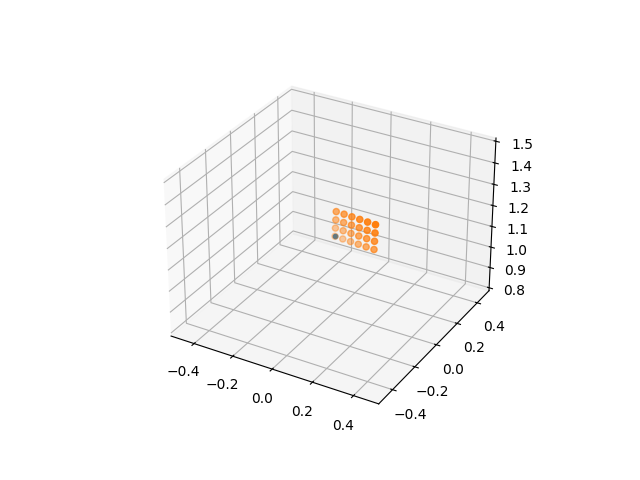

In [38]:
ax = plt.figure().add_subplot(111,projection='3d')
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_zlim([0.8, 1.5])

ax.scatter(cal3d[18,0],cal3d[18,1],cal3d[18,2],'r',s=10)
ax.scatter(cal3d[:,0],cal3d[:,1],cal3d[:,2])


In [16]:
import numpy as np
# checkerboard_points = np.zeros((8, 10, 24, 3)) * jnp.nan

calibration_points = entry['calibration_points']
checkerboard_points = entry['calibration_points']
camera_params = entry['camera_calibration']

x0, board_rotation = extract_origin(camera_params, checkerboard_points[:, 5:])
x0
camera_params_zeroed = shift_calibration(camera_params, x0, board_rotation, zoffset=0)
camera_params_zeroed

{'dist': array([[-0.15376282,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.01628816,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.18234472,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.17034325,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.0455877 ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.04561709,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.00445027,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.18803985,  0.        ,  0.        ,  0.        ,  0.        ]]),
 'mtx': array([[1.79935227, 1.79935227, 1.0235    , 0.7675    ],
        [1.95945386, 1.95945386, 1.0235    , 0.7675    ],
        [1.82537549, 1.82537549, 1.0235    , 0.7675    ],
        [1.80200491, 1.80200491, 1.0235    , 0.7675    ],
        [1.33337688, 1.33337688, 1.0235    , 0.7675    ],
        [2.23311625, 2.23311625, 1.0235    , 0.7675    ],
        [1.58064605, 1.58064605, 1.

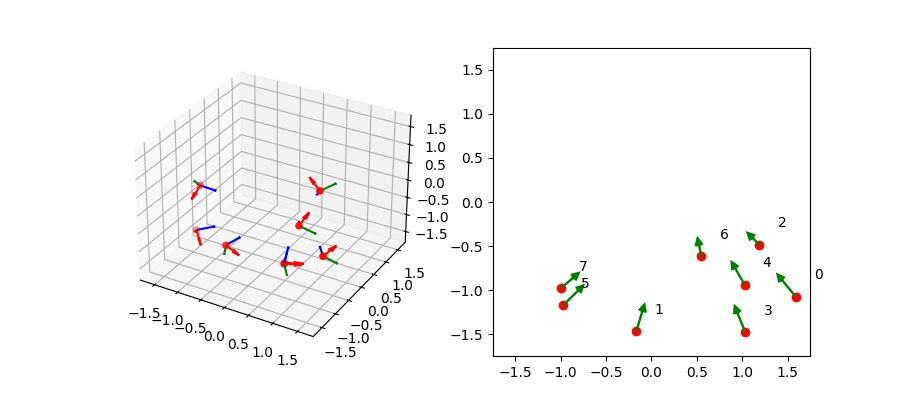

In [17]:
plot_cal(camera_params_zeroed)
